In [134]:
import os                          # operating system interfaces
import glob                        # working with OS pathnames
import time                        # time processing
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # data visualization purposes
import seaborn as sns              # statistical data visualization
sns.set_theme()

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb                       # Extreme Gradient Boosting library
from IPython.display import clear_output    # Display function to clear notebook cell's output



In [135]:
df=pd.read_csv('Final-TamilNadu-Data.csv')
df.head()

From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
0  2017-06-16 13:00:00  2017-06-16 14:00:00      38.000000     10.000000   
1  2017-06-16 14:00:00  2017-06-16 15:00:00      26.249079     47.452061   
2  2017-06-16 15:00:00  2017-06-16 16:00:00      26.249079     47.452061   
3  2017-06-16 16:00:00  2017-06-16 17:00:00      26.249079     47.452061   
4  2017-06-16 17:00:00  2017-06-16 18:00:00      26.249079     47.452061   

   NO (ug/m3)  NO2 (ug/m3)  NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
0    2.700000     7.100000   6.200000     6.947964     4.100000    0.710000   
1    3.761351    10.638806   8.543631     6.947964     7.499231    0.892143   
2    3.761351    10.638806   8.543631     6.947964     7.499231    0.892143   
3    3.761351    10.638806   8.543631     6.947964     7.499231    0.892143   
4    3.761351    10.638806   8.543631     6.947964     7.499231    0.892143   

   ...   RF (mm)   State  AQI_PM2.5  AQI_PM10  AQI_NO2  AQI_SO2  AQI_CO  \
0  ...  8.500000  Kerala        106         9        9        5      36   
1  ...  0.337759  Kerala         80        44       13        9      45   
2  ...  0.337759  Kerala         80        44       13        9      45   
3  ...  0.337759  Kerala         80        44       13        9      45   
4  ...  0.337759  Kerala         80        44       13        9      45   

   AQI_O3 Max_AQI  AQI_Category  
0      17     106      Moderate  
1      25      80  Satisfactory  
2      25      80  Satisfactory  
3      25      80  Satisfactory  
4      25      80  Satisfactory  

[5 rows x 27 columns]

In [136]:
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')
df = create_dt_index(df)
df.head(2)

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2017-06-16 13:00:00      38.000000     10.000000    2.700000     7.100000   
2017-06-16 14:00:00      26.249079     47.452061    3.761351    10.638806   

                     NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
datetime                                                               
2017-06-16 13:00:00   6.200000     6.947964     4.100000    0.710000   
2017-06-16 14:00:00   8.543631     6.947964     7.499231    0.892143   

                     Ozone (ug/m3)  Temp (degree C)  ...   RF (mm)   State  \
datetime                                             ...                     
2017-06-16 13:00:00      18.300000        30.100000  ...  8.500000  Kerala   
2017-06-16 14:00:00      27.677541        27.975931  ...  0.337759  Kerala   

                     AQI_PM2.5  AQI_PM10  AQI_NO2  AQI_SO2 AQI_CO  AQI_O3  \
datetime                                                                    
2017-06-16 13:00:00        106         9        9        5     36      17   
2017-06-16 14:00:00         80        44       13        9     45      25   

                     Max_AQI  AQI_Category  
datetime                                    
2017-06-16 13:00:00      106      Moderate  
2017-06-16 14:00:00       80  Satisfactory  

[2 rows x 25 columns]

In [137]:
df.isnull().sum()

PM2.5 (ug/m3)      0
PM10 (ug/m3)       0
NO (ug/m3)         0
NO2 (ug/m3)        0
NOx (ppb)          0
NH3 (ug/m3)        0
SO2 (ug/m3)        0
CO (mg/m3)         0
Ozone (ug/m3)      0
Temp (degree C)    0
RH (%)             0
WS (m/s)           0
WD (deg)           0
SR (W/mt2)         0
AT (degree C)      0
RF (mm)            0
State              0
AQI_PM2.5          0
AQI_PM10           0
AQI_NO2            0
AQI_SO2            0
AQI_CO             0
AQI_O3             0
Max_AQI            0
AQI_Category       0
dtype: int64

In [138]:
# Specify the columns you want to remove
columns_to_remove = ['AQI_PM2.5', 'AQI_PM10','AQI_NO2','AQI_SO2','AQI_CO','AQI_O3']

# Remove the specified columns
df.drop(columns=columns_to_remove, inplace=True)


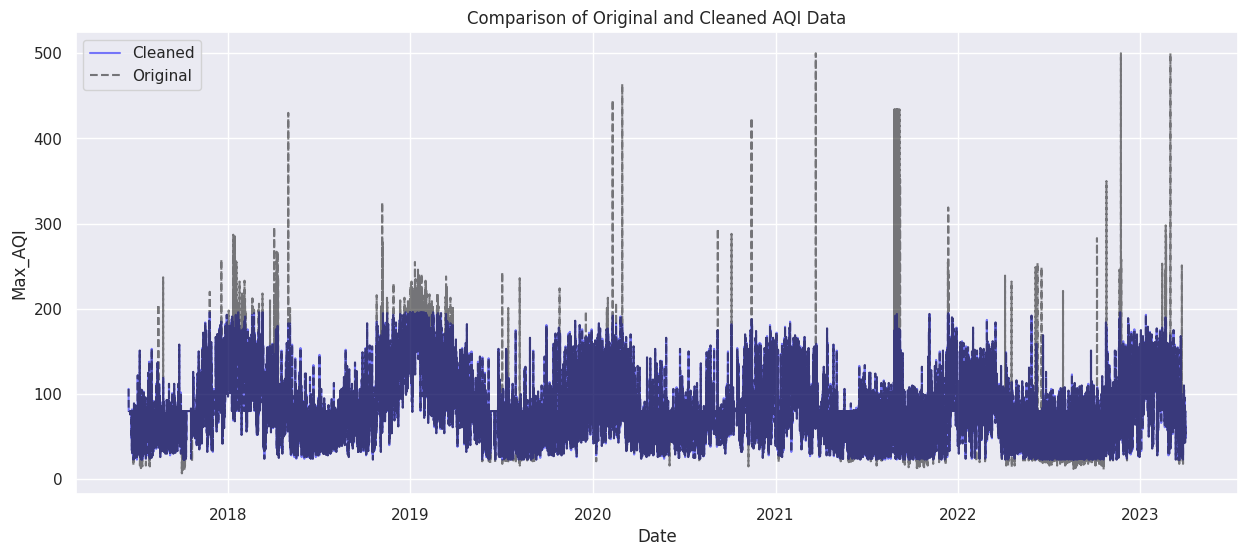

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Make a copy of the original 'Max_AQI' column for comparison
df['Max_AQI_Original'] = df['Max_AQI'].copy()

# Identify outliers based on the quantile thresholds
q_low = df['Max_AQI'].quantile(0.01)
q_high = df['Max_AQI'].quantile(0.99)

# Replace values outside the quantile thresholds with NaN
df.loc[(df['Max_AQI'] < q_low) | (df['Max_AQI'] > q_high), 'Max_AQI'] = np.nan

# Impute NaNs using linear interpolation
df['Max_AQI'].interpolate(method='linear', inplace=True)

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Max_AQI'], label='Cleaned', color='blue', alpha=0.5)
plt.plot(df.index, df['Max_AQI_Original'], label='Original', color='black', linestyle='--', alpha=0.5)
plt.title('Comparison of Original and Cleaned AQI Data')
plt.xlabel('Date')
plt.ylabel('Max_AQI')
plt.legend()
plt.show()


In [140]:
# Specify the columns you want to remove
columns_to_remove = ['Max_AQI_Original']

# Remove the specified columns
df.drop(columns=columns_to_remove, inplace=True)


In [141]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = len(feature_groups) // columns + (len(feature_groups) % columns > 0)  # Calculate the number of rows
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4 * rows))
    fig.tight_layout(pad=3.0)

    for i, (group, features) in enumerate(feature_groups.items()):
        row = i // columns
        col = i % columns
        ax = axes[row, col] if rows > 1 else axes[col]  # Handle single row case

        for feature in features:
            df_feature = dataframe[feature].dropna()
            df_feature = df_feature.groupby(df_feature.index.year).mean()
            sns.lineplot(data=df_feature, label=feature, ax=ax)
        ax.set_title(group)
        ax.set_xlabel('Year')
        ax.legend()

    # Hide empty subplots
    for i in range(len(feature_groups), rows * columns):
        row = i // columns
        col = i % columns
        fig.delaxes(axes[row, col])

    plt.show()


In [143]:
df.columns

Index(['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)',
       'SR (W/mt2)', 'AT (degree C)', 'RF (mm)', 'State', 'Max_AQI',
       'AQI_Category'],
      dtype='object')

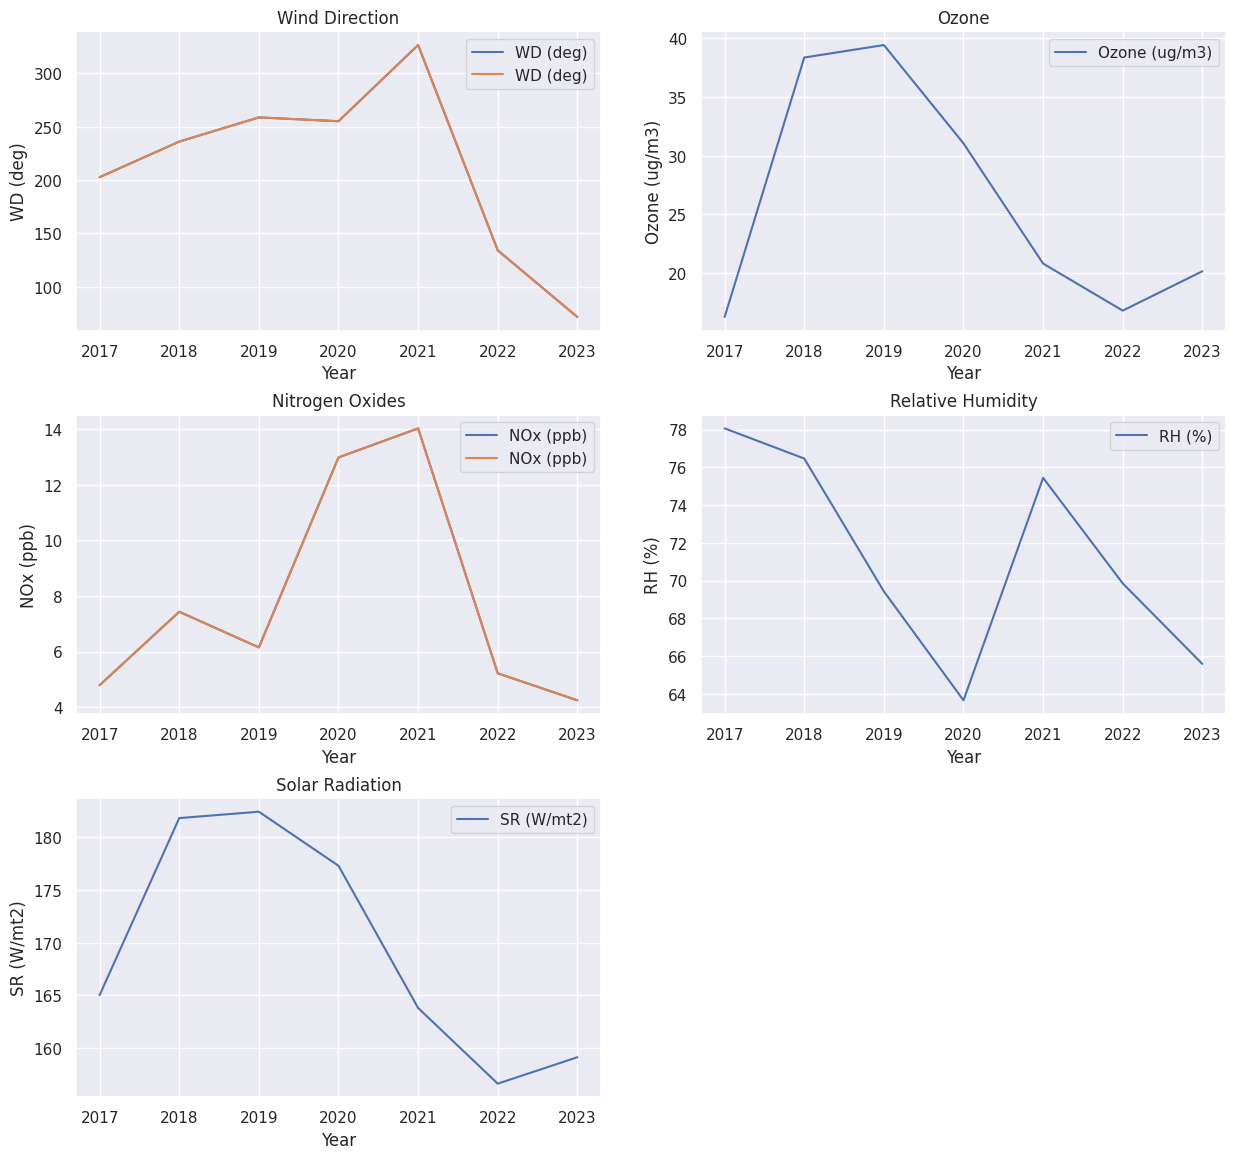

In [144]:
groups = {



    'Wind Direction':    ["WD (deg)", "WD (deg)"],
    'Ozone':             ['Ozone (ug/m3)'],
    'Nitrogen Oxides':   ['NOx (ppb)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)'],
    'Solar Radiation':   ['SR (W/mt2)'],

}

plot_feature_similarities(df, groups, columns=2)

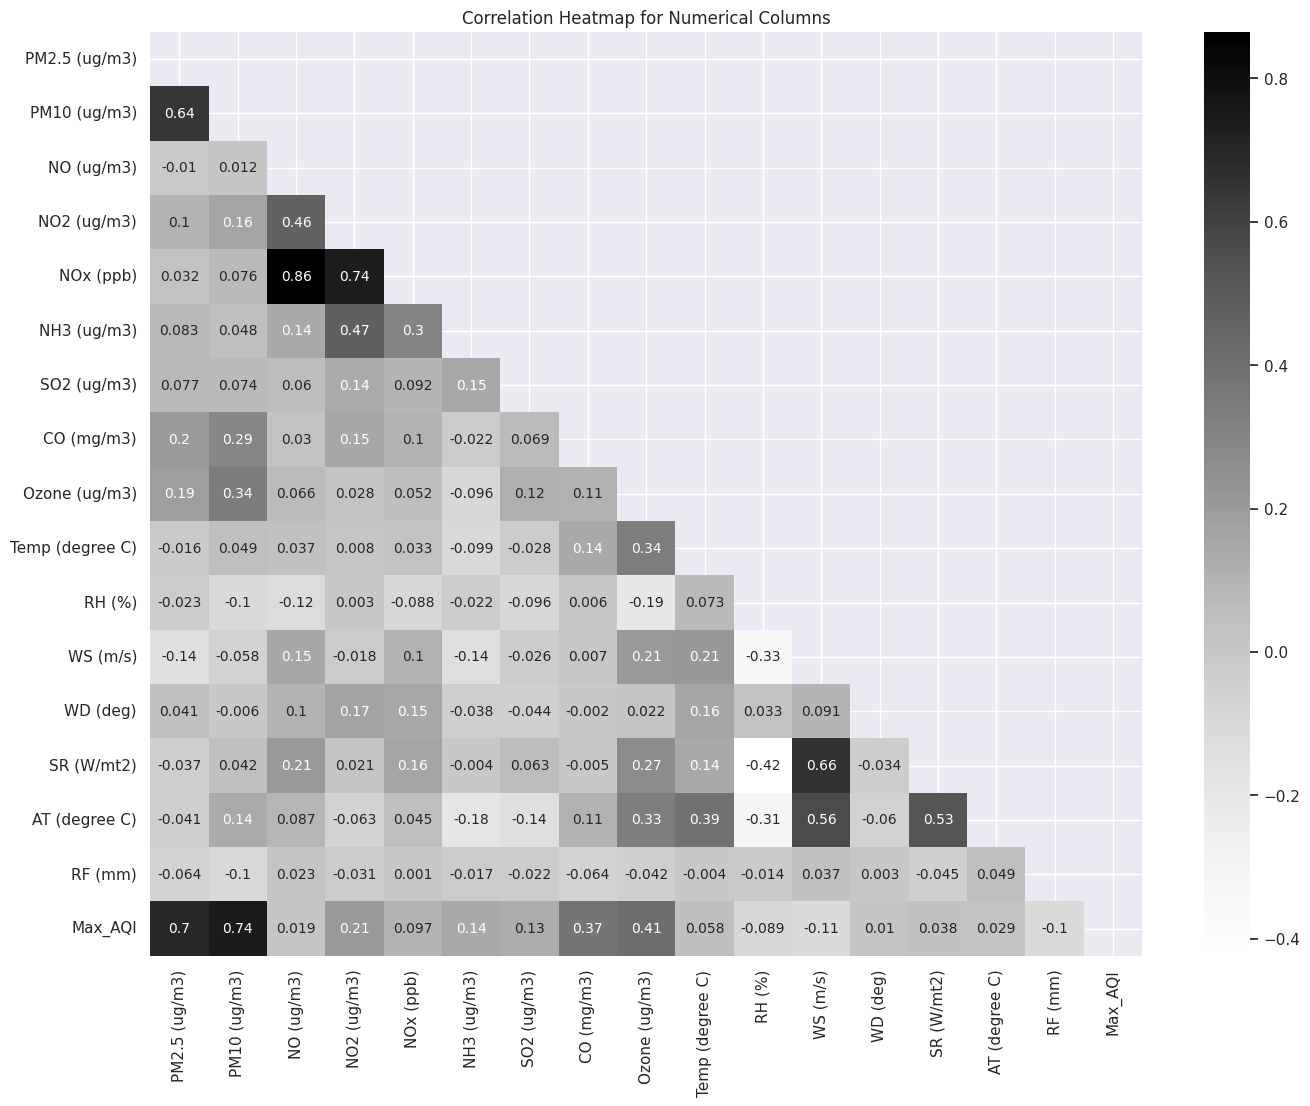

In [145]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Looking at correlation among numerical columns
plt.figure(figsize=(16, 12))
correlation_matrix = numerical_df.corr().round(3)
sns.heatmap(correlation_matrix, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), annot=True, cmap='Greys', annot_kws={"size": 10})
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()


In [146]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection based on correlation with target variable 'Max_AQI'
corr_target = abs(correlation_matrix['Max_AQI'])
relevant_features = corr_target[corr_target > 0.5]
relevant_features = relevant_features.drop('Max_AQI')  # Drop the target variable itself
relevant_features = relevant_features.sort_values(ascending=False)

print("Features with correlation greater than 0.4 with Max_AQI:")
print(relevant_features)


Features with correlation greater than 0.4 with Max_AQI:
PM10 (ug/m3)     0.745
PM2.5 (ug/m3)    0.698
Name: Max_AQI, dtype: float64


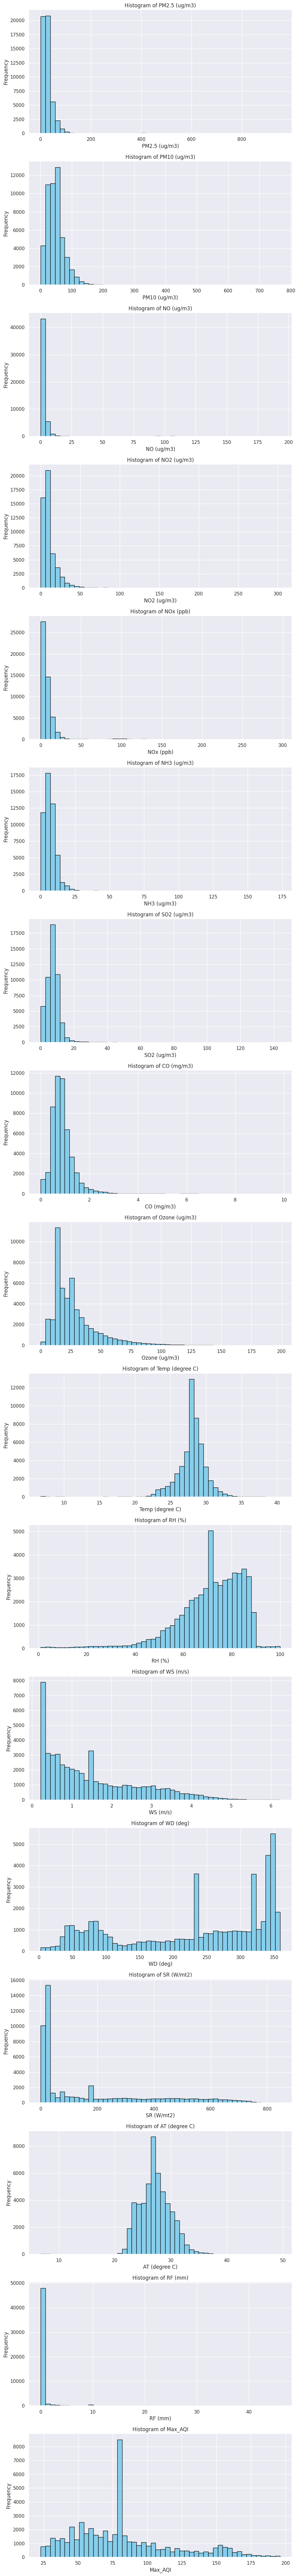

In [147]:
import matplotlib.pyplot as plt

def histo_plotter(df, bins=50):
    """
    Generate histogram plots for numerical columns in a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        bins (int): Number of bins for the histogram. Default is 50.
    """
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numeric_columns)
    fig, axs = plt.subplots(num_cols, 1, figsize=(10, 5*num_cols))
    if num_cols == 1:
        axs = [axs]
    for i, col in enumerate(numeric_columns):
        ax = axs[i]
        ax.hist(df[col], bins=bins, color='skyblue', edgecolor='black')
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Assuming df is your DataFrame
histo_plotter(df, bins=50)


In [148]:
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts and industrial emissions.
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly the combustion of fossil fuels.
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}

In [149]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [150]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            # Keep only the NOx feature, as it combines both NO (Nitrogen Oxide) and NO2 (Nitrogen Dioxide)
            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

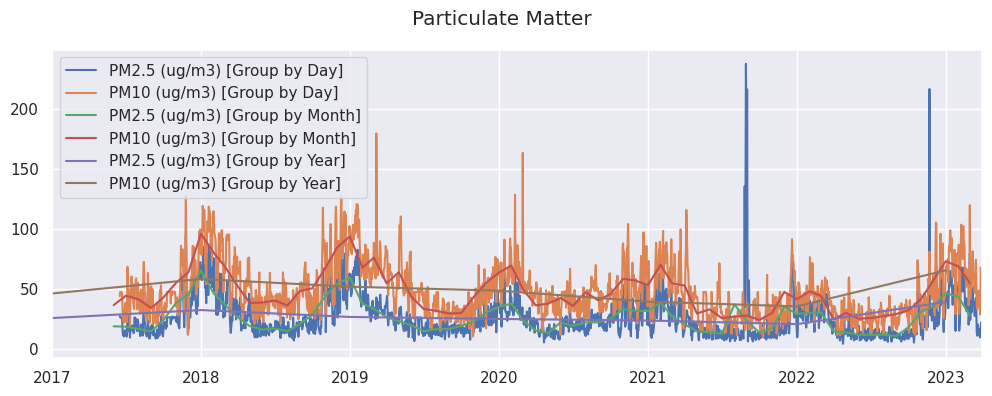

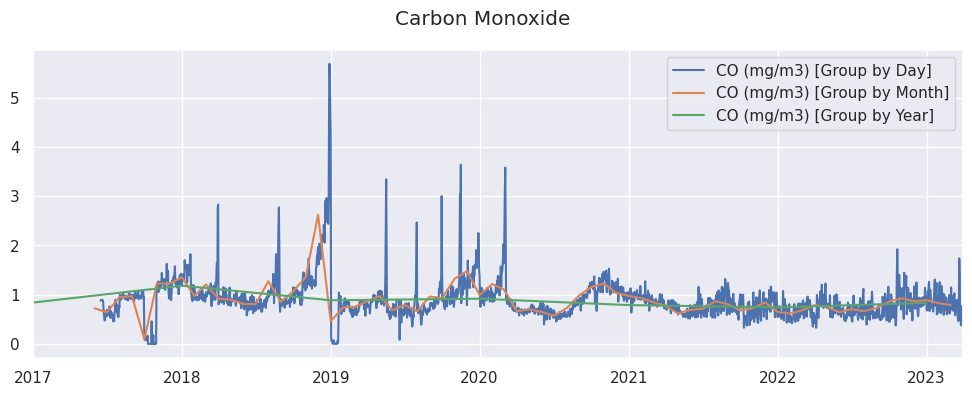

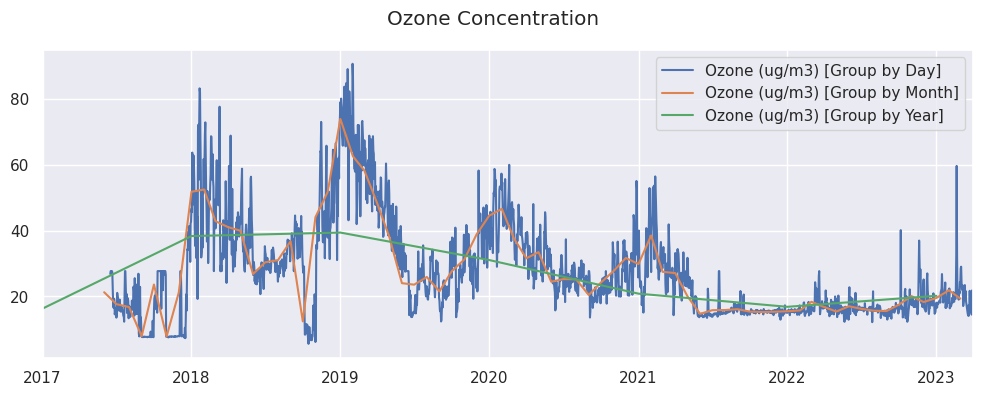

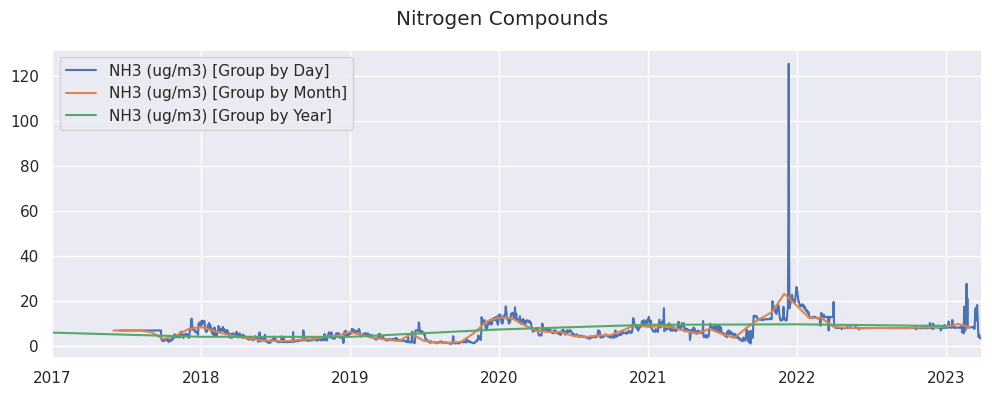

In [151]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

In [152]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

**Lets understand seasonal patterns on yearly basis**

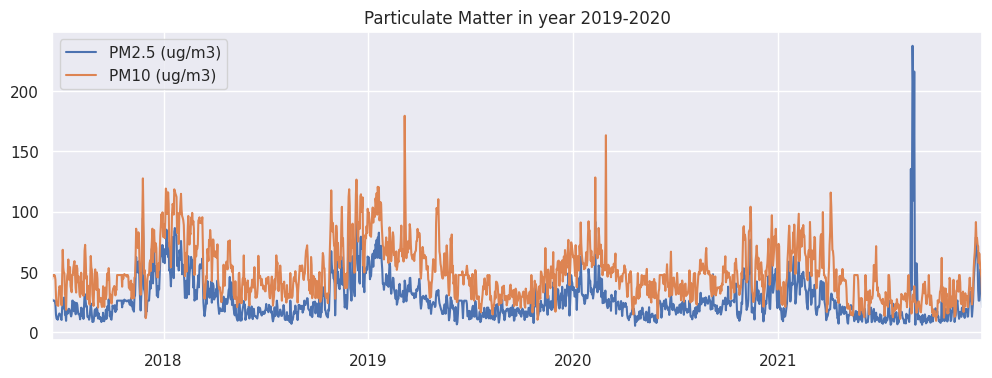

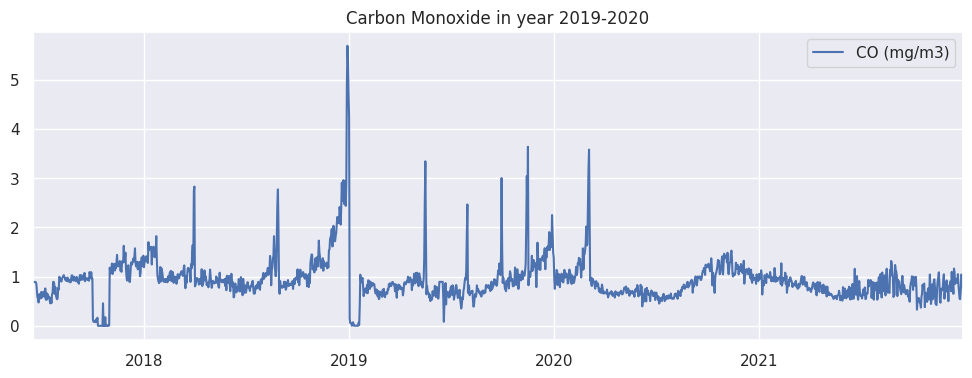

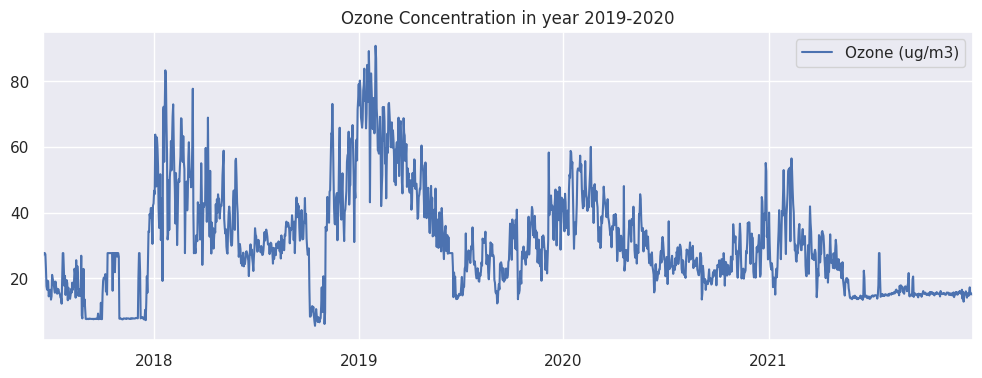

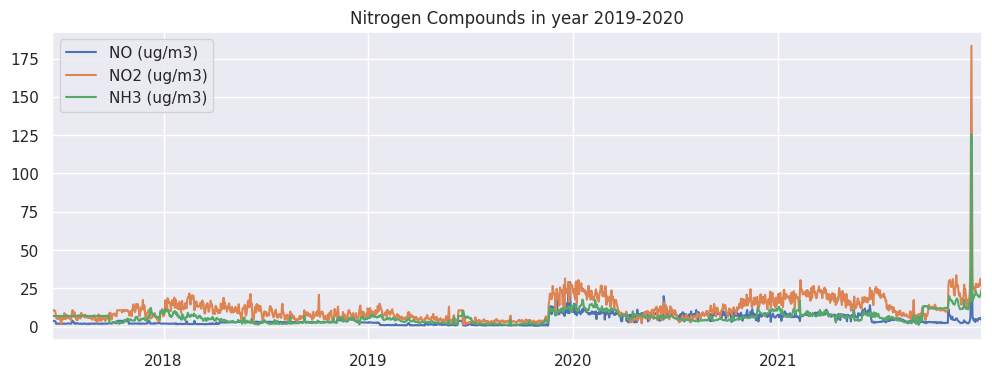

In [153]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2017 and datetime < 2022').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

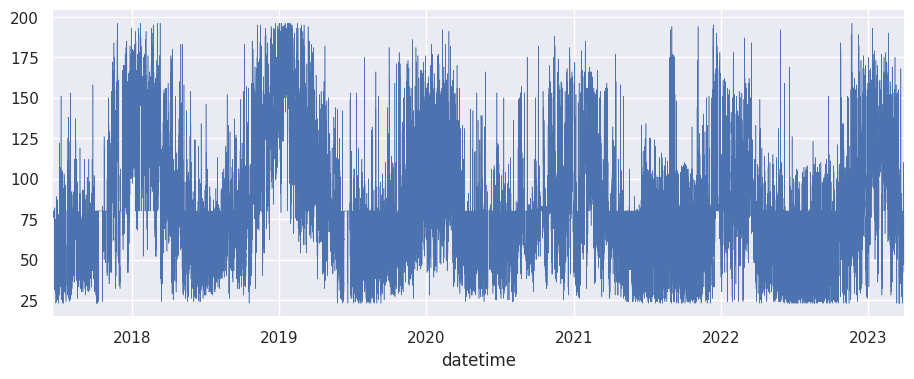

In [154]:
df['Max_AQI'].plot(linewidth=0.4);

**Decomposition Analysis**

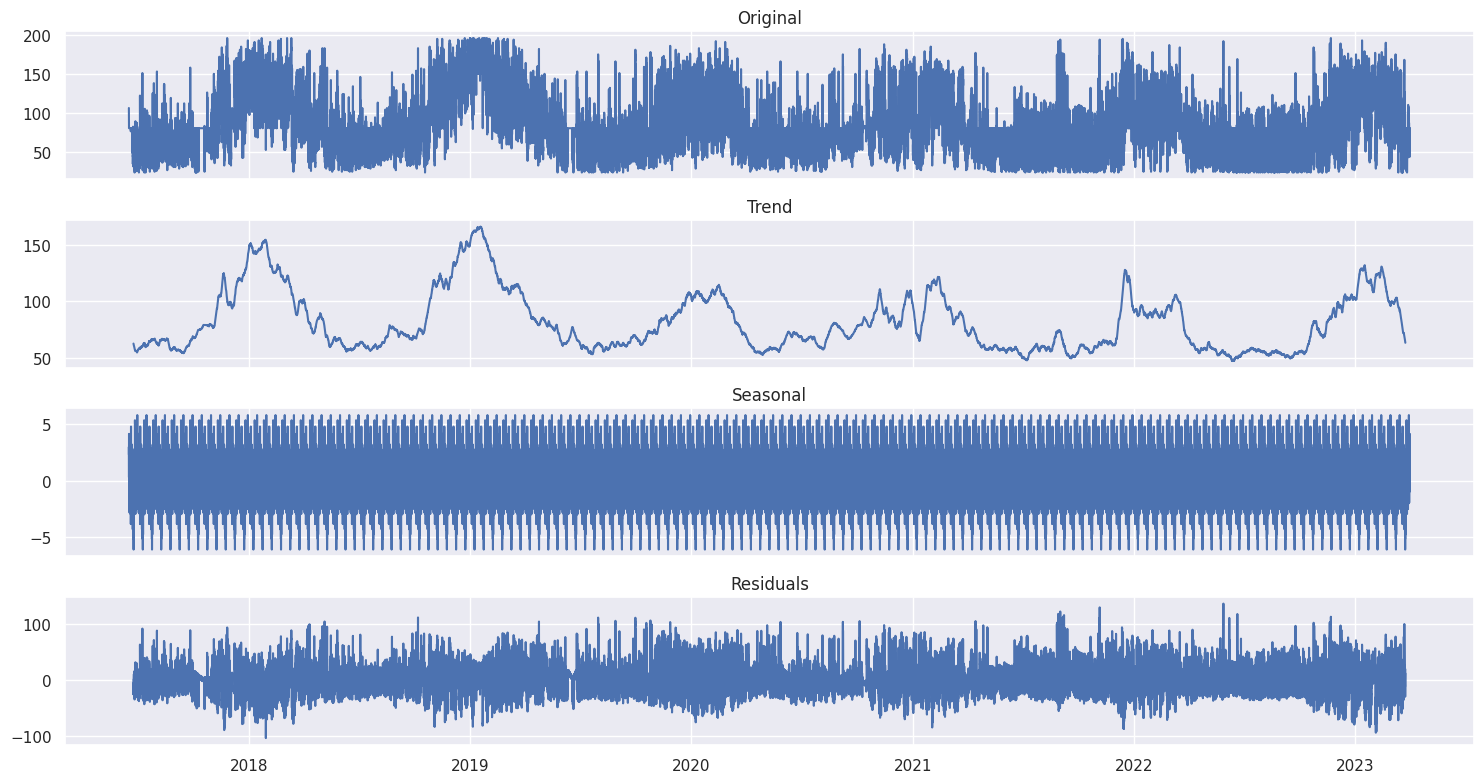

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'df' is your DataFrame and it is indexed by a datetime type
# The 'Max_AQI' column contains the time series data you want to decompose

# Perform the decomposition assuming a period of 365 days for annual seasonality
# Note: If your data includes leap years, this will not perfectly align every year.
# You might need to preprocess the data to account for that, or use 365.25 to approximate the alignment.
decomposition = seasonal_decompose(df['Max_AQI'], model='additive', period=365)

# Plot the decomposed components of the time series
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

# Original data
ax1.plot(decomposition.observed)
ax1.set_title('Original')
ax1.grid(True)

# Trend component
ax2.plot(decomposition.trend)
ax2.set_title('Trend')
ax2.grid(True)

# Seasonal component
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')
ax3.grid(True)

# Residuals
ax4.plot(decomposition.resid)
ax4.set_title('Residuals')
ax4.grid(True)

# Tight layout to prevent overlap
plt.tight_layout()
plt.show()


Original: The top plot displays the raw data of the AQI over time. It exhibits variability and potential outliers (spikes) which may need to be addressed.

Trend: The second plot suggests some long-term patterns in the data, possibly related to changes in environmental policy, urban development, or other factors.

Seasonal: The third plot shows a consistent seasonal pattern, confirming the presence of seasonality in the data. The consistent amplitude and frequency indicate that the seasonality is stable over time, which is good for modeling.

Residuals: The bottom plot shows the residuals after removing the trend and seasonal components. Ideally, this should resemble white noise, indicating that the model has captured the primary structures in the data. While there are still some spikes present, which are likely the outliers from the original data, the absence of a clear pattern suggests that the trend and seasonal components have been reasonably well captured.

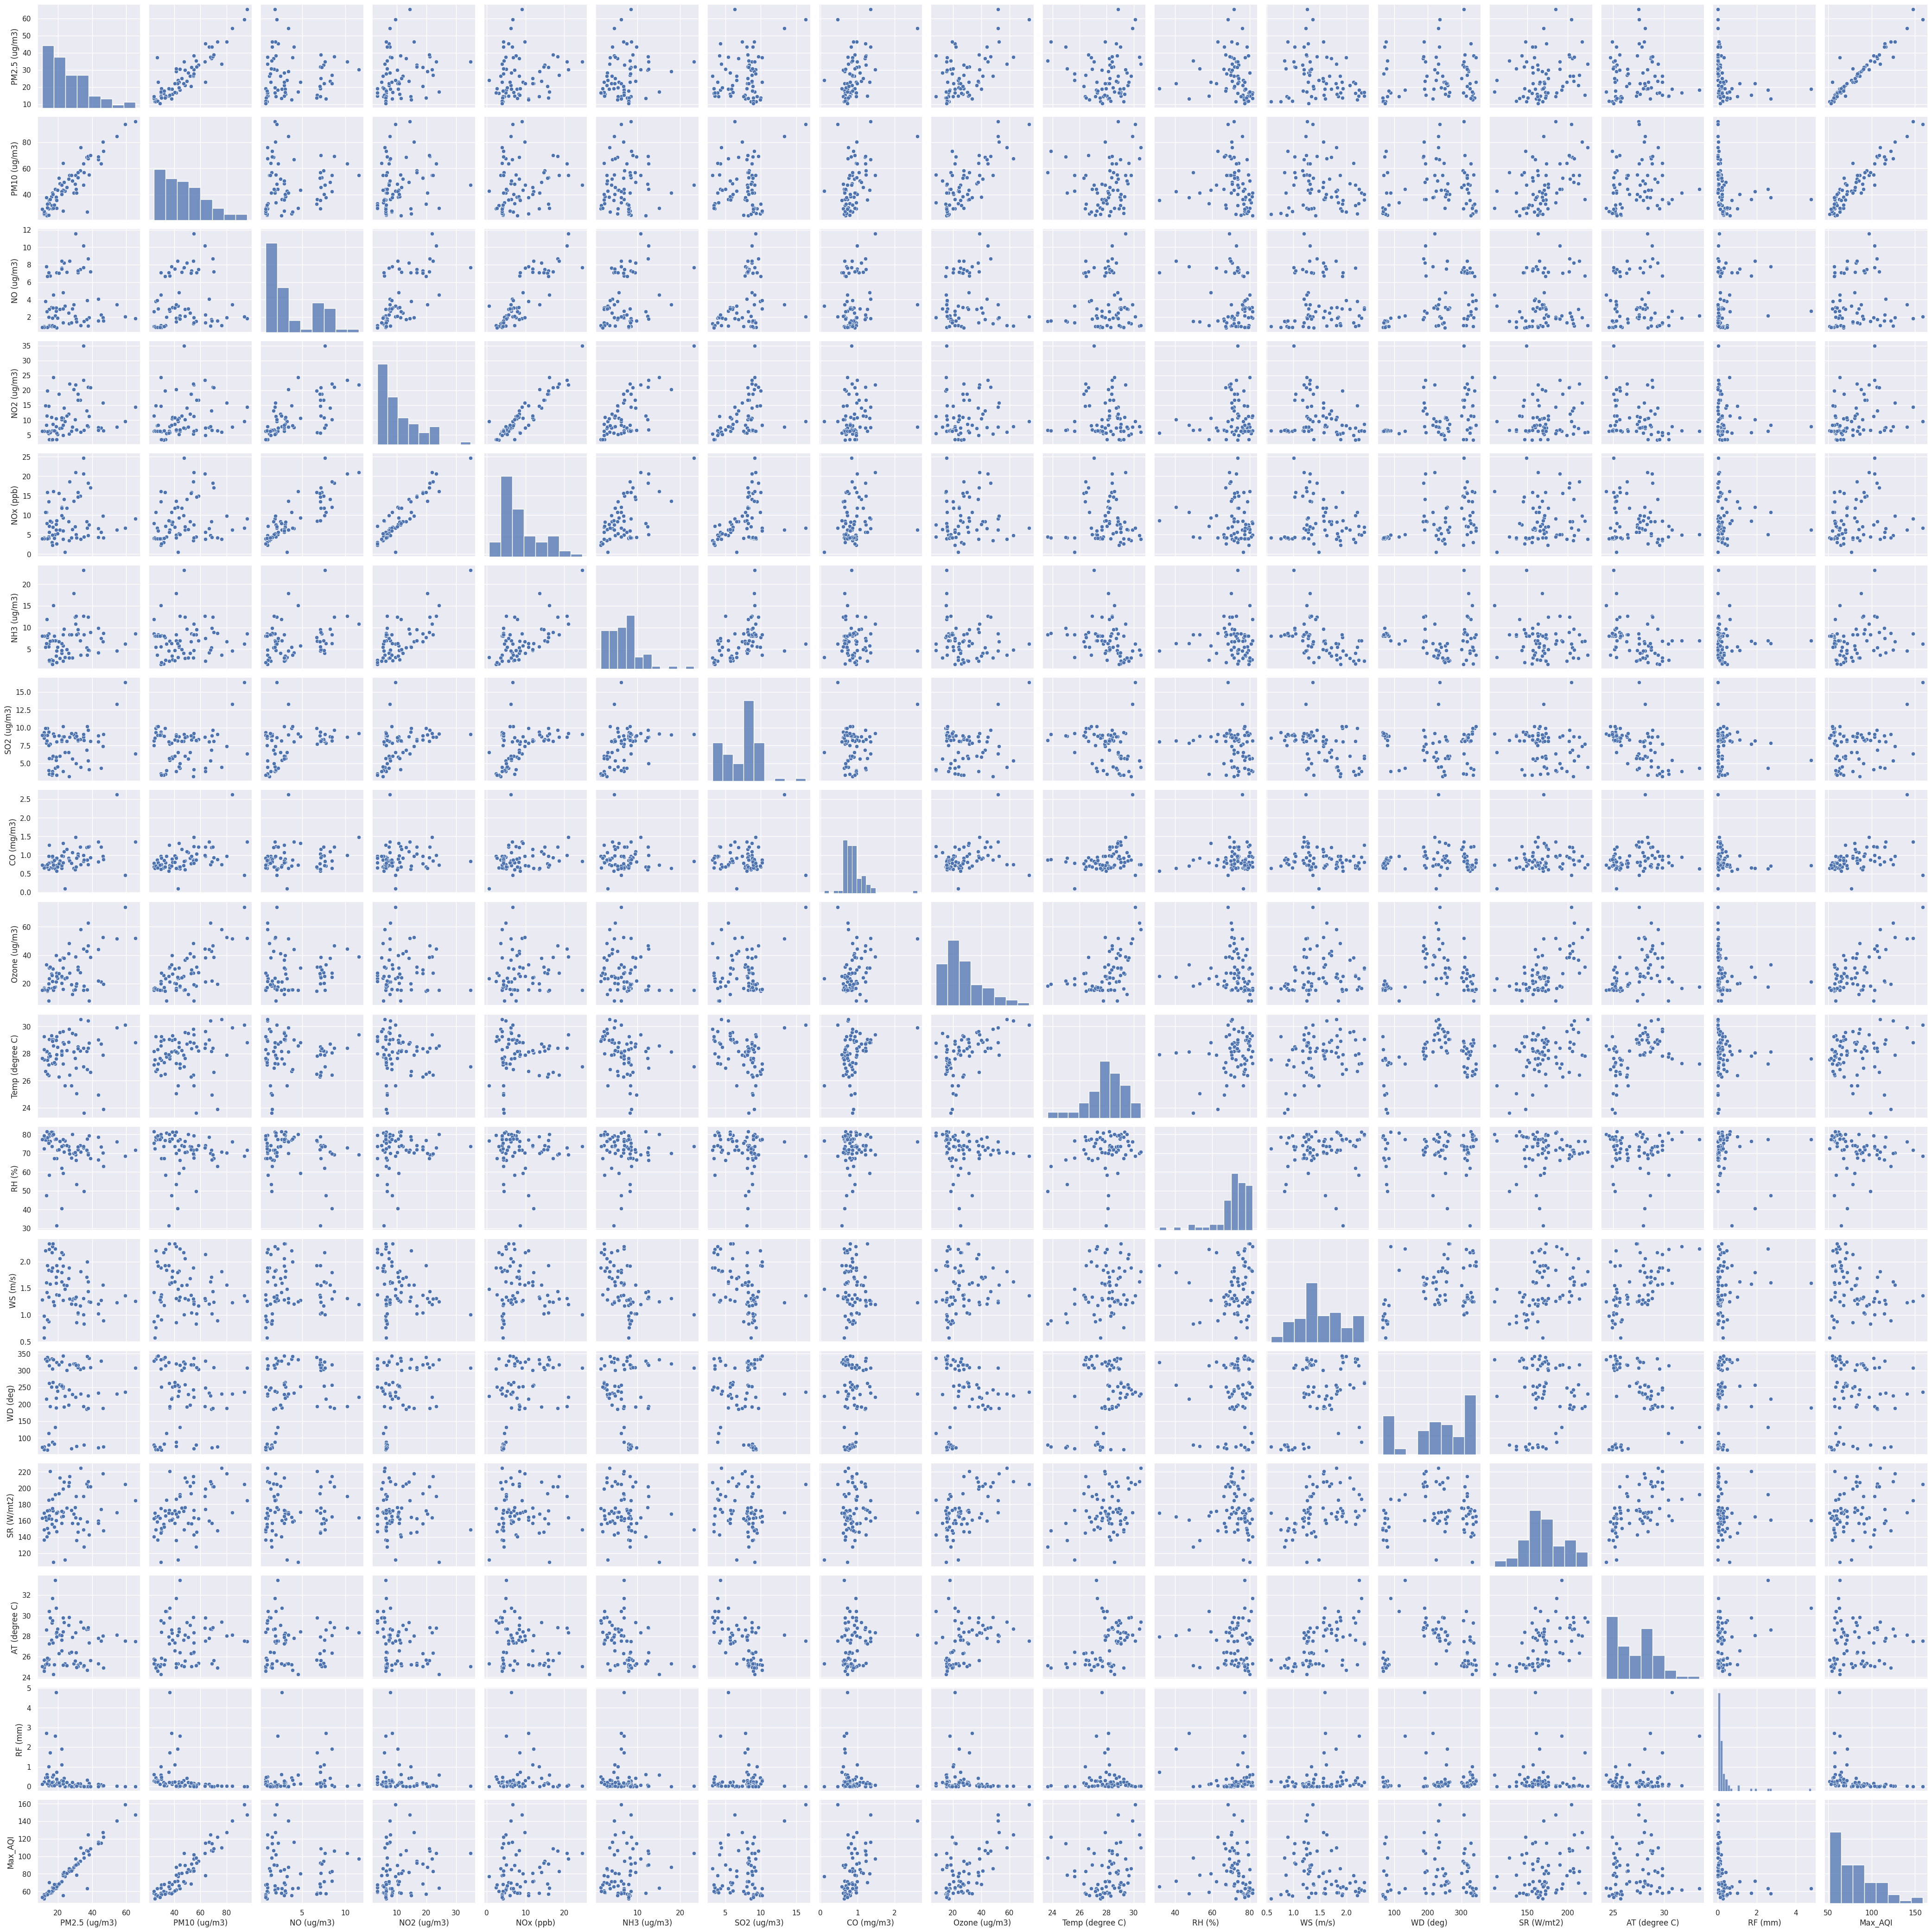

In [156]:
sns.pairplot(slice_groups['Group by Month'])

In [157]:
df = df.resample('60min').mean(numeric_only=True)

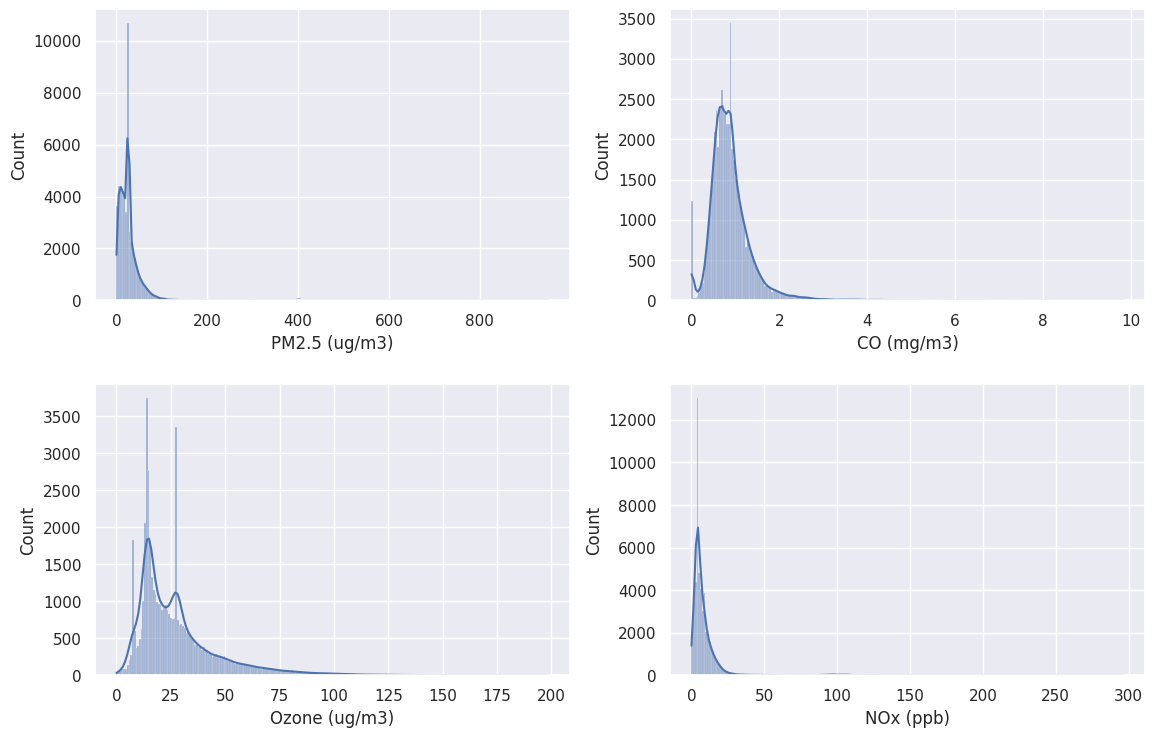

In [158]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NOx (ppb)'], bins=250, kde=True, ax=axes[1,1])

plt.show()

<Axes: xlabel='datetime'>

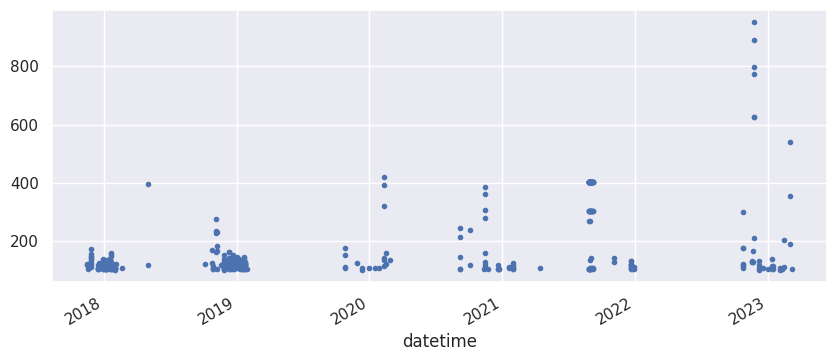

In [159]:
df.query('`PM2.5 (ug/m3)` > 100')['PM2.5 (ug/m3)'].plot(style='.', figsize=(10,4))

In [160]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50747 entries, 2017-06-16 13:00:00 to 2023-03-31 23:00:00
Freq: 60T
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PM2.5 (ug/m3)    50747 non-null  float64
 1   PM10 (ug/m3)     50747 non-null  float64
 2   NO (ug/m3)       50747 non-null  float64
 3   NO2 (ug/m3)      50747 non-null  float64
 4   NOx (ppb)        50747 non-null  float64
 5   NH3 (ug/m3)      50747 non-null  float64
 6   SO2 (ug/m3)      50747 non-null  float64
 7   CO (mg/m3)       50747 non-null  float64
 8   Ozone (ug/m3)    50747 non-null  float64
 9   Temp (degree C)  50747 non-null  float64
 10  RH (%)           50747 non-null  float64
 11  WS (m/s)         50747 non-null  float64
 12  WD (deg)         50747 non-null  float64
 13  SR (W/mt2)       50747 non-null  float64
 14  AT (degree C)    50747 non-null  float64
 15  RF (mm)          50747 non-null  float64
 16  Max_AQI      

In [161]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [162]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

In [163]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


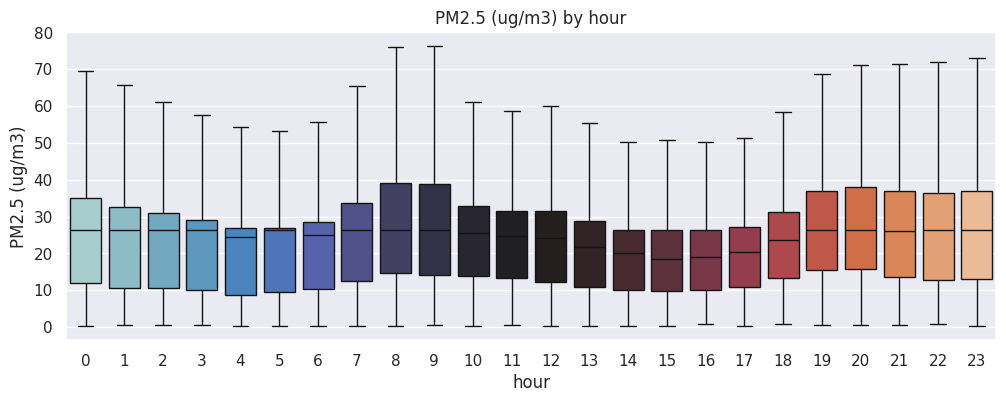

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


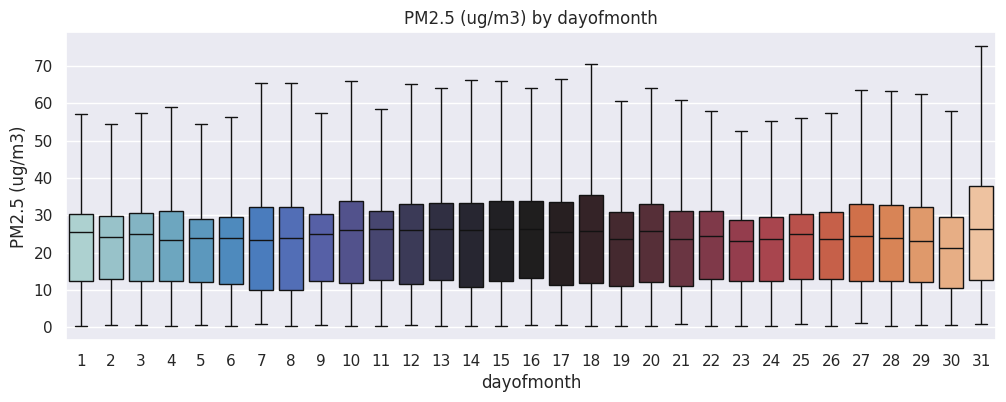

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


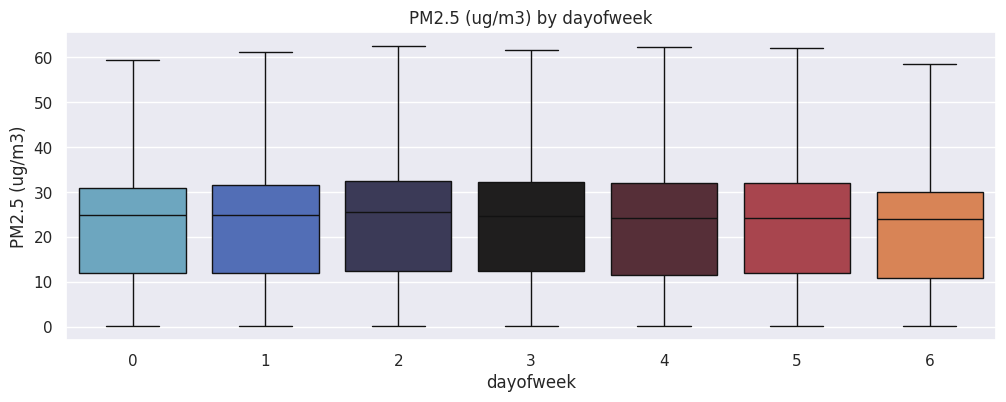

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


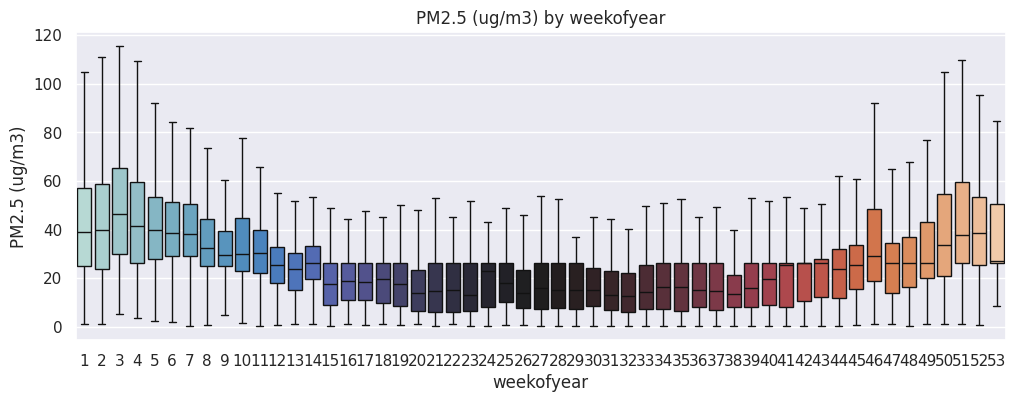

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


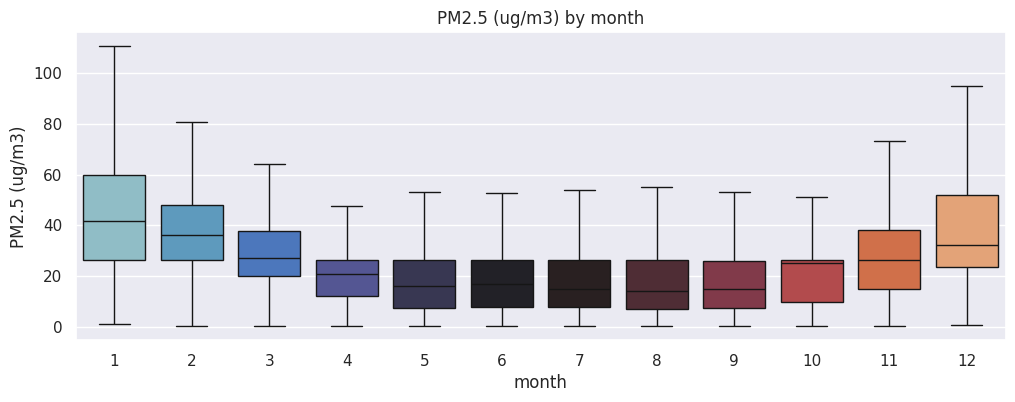

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


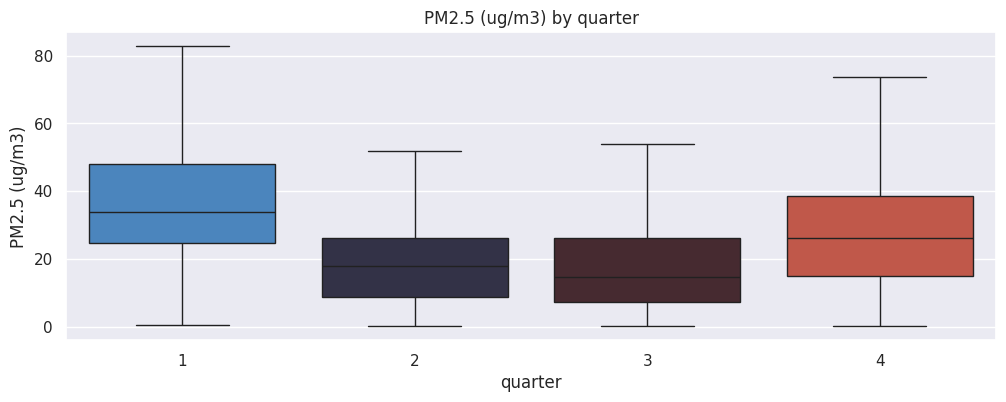

<ipython-input-163-27984da068bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


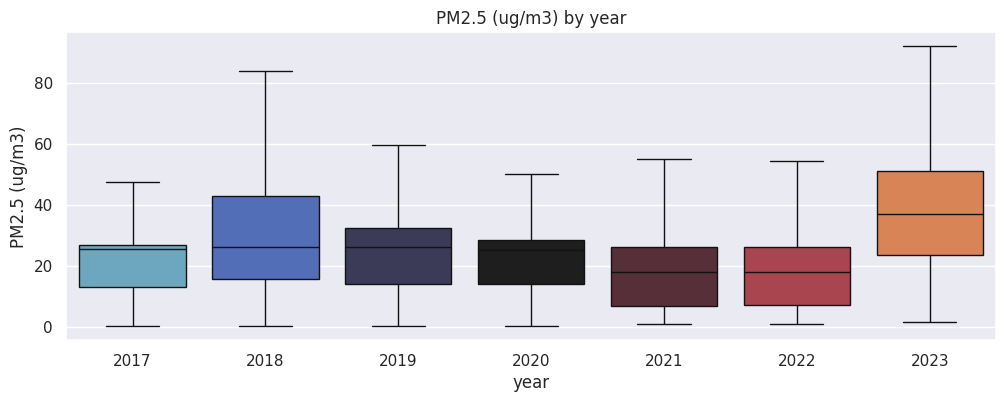

In [164]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

In [165]:
def create_lag_features(df):
    """
    Create lag features for the target variable 'Max_AQI' with lags of 1 year and 2 years.

    Parameters:
        df (DataFrame): The DataFrame containing the data.

    Returns:
        DataFrame: The DataFrame with lag features added.
    """
    df = df.copy()
    df['aqi_lag_1Y'] = df['Max_AQI'].shift(365*24)   # 1 year lag
    df['aqi_lag_2Y'] = df['Max_AQI'].shift(730*24)   # 2 year lag
    return df


In [166]:
lag_features = ['aqi_lag_1Y', 'aqi_lag_2Y']
df = create_lag_features(df)
df.head()

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2017-06-16 13:00:00      38.000000     10.000000    2.700000     7.100000   
2017-06-16 14:00:00      26.249079     47.452061    3.761351    10.638806   
2017-06-16 15:00:00      26.249079     47.452061    3.761351    10.638806   
2017-06-16 16:00:00      26.249079     47.452061    3.761351    10.638806   
2017-06-16 17:00:00      26.249079     47.452061    3.761351    10.638806   

                     NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
datetime                                                               
2017-06-16 13:00:00   6.200000     6.947964     4.100000    0.710000   
2017-06-16 14:00:00   8.543631     6.947964     7.499231    0.892143   
2017-06-16 15:00:00   8.543631     6.947964     7.499231    0.892143   
2017-06-16 16:00:00   8.543631     6.947964     7.499231    0.892143   
2017-06-16 17:00:00   8.543631     6.947964     7.499231    0.892143   

                     Ozone (ug/m3)  Temp (degree C)  ...  hour  dayofmonth  \
datetime                                             ...                     
2017-06-16 13:00:00      18.300000        30.100000  ...    13          16   
2017-06-16 14:00:00      27.677541        27.975931  ...    14          16   
2017-06-16 15:00:00      27.677541        27.975931  ...    15          16   
2017-06-16 16:00:00      27.677541        27.975931  ...    16          16   
2017-06-16 17:00:00      27.677541        27.975931  ...    17          16   

                     dayofweek  dayofyear  weekofyear  month  quarter  year  \
datetime                                                                      
2017-06-16 13:00:00          4        167          24      6        2  2017   
2017-06-16 14:00:00          4        167          24      6        2  2017   
2017-06-16 15:00:00          4        167          24      6        2  2017   
2017-06-16 16:00:00          4        167          24      6        2  2017   
2017-06-16 17:00:00          4        167          24      6        2  2017   

                     aqi_lag_1Y  aqi_lag_2Y  
datetime                                     
2017-06-16 13:00:00         NaN         NaN  
2017-06-16 14:00:00         NaN         NaN  
2017-06-16 15:00:00         NaN         NaN  
2017-06-16 16:00:00         NaN         NaN  
2017-06-16 17:00:00         NaN         NaN  

[5 rows x 27 columns]

In [167]:
def replace_lag_na(df, how):
    '''
    Replaces missing values by applying various methods.

    Some additional ideas to implement include:
      1. Replace lag NaNs with the overall chosen method for that variable
      2. Replace lag NaNs with the time chosen method for the variable in the window value
    '''

    # Replace lag NaNs with zeros
    if how == 'zeros':
        return df.fillna(0)
    # Drop missing lag records
    if how == 'drop':
        return df.dropna(how='any')

# Example usage:
# Assuming 'df' is your DataFrame with lag features
# Replace missing values with zeros
df_filled = replace_lag_na(df, how='zeros')

# Drop rows with missing values
df_dropped = replace_lag_na(df, how='drop')


# Stationarity Test #

**Auto correlation Plot For Target Variable**

<Figure size 1200x600 with 0 Axes>

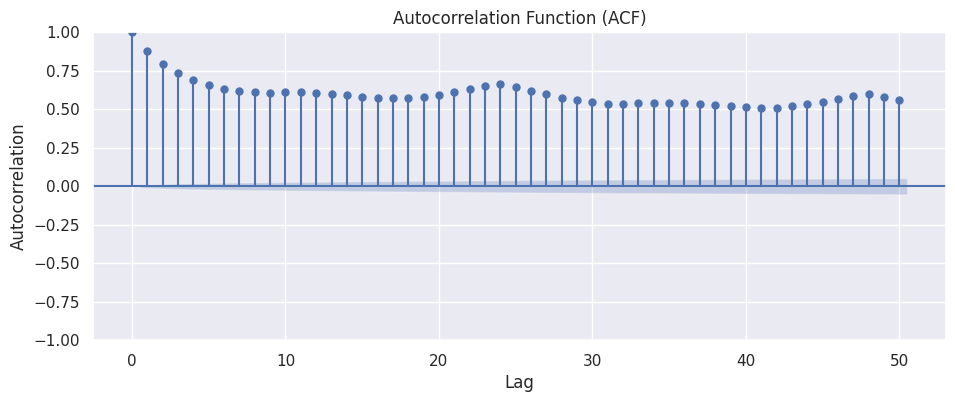

In [168]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' is your DataFrame with the time series data and 'Max_AQI' is your target variable
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['Max_AQI'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

**Partial Auto-Correlation Plot for Target Variable**

<Figure size 1200x600 with 0 Axes>

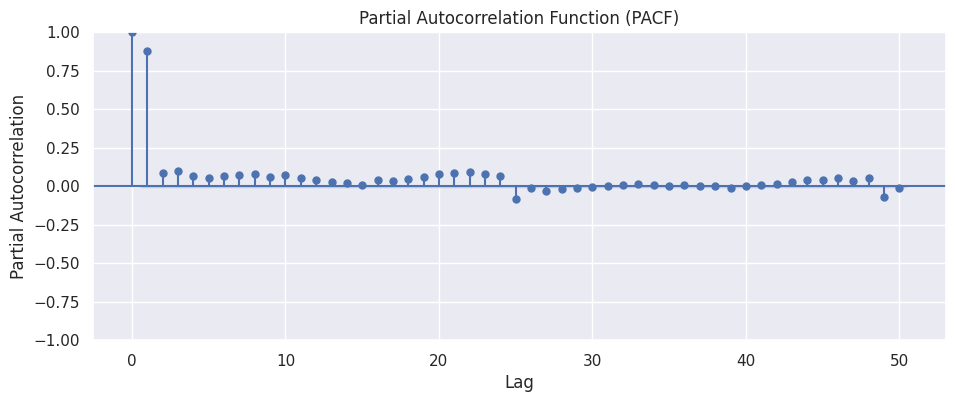

In [169]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['Max_AQI'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

<Figure size 1200x600 with 0 Axes>

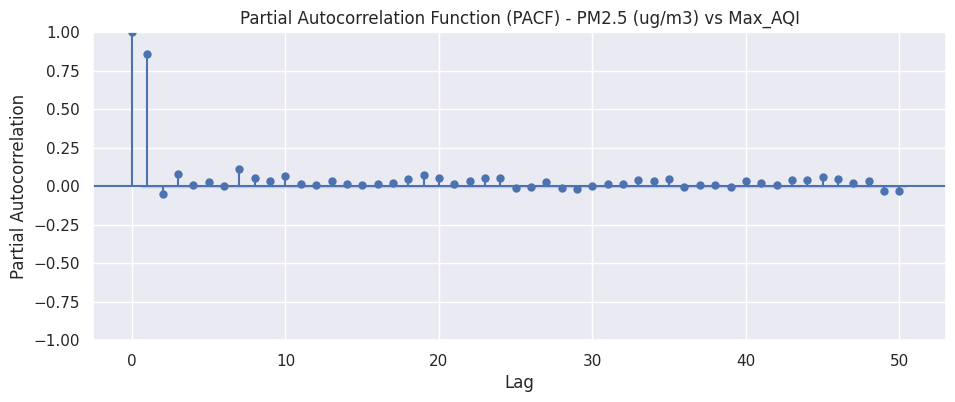

<Figure size 1200x600 with 0 Axes>

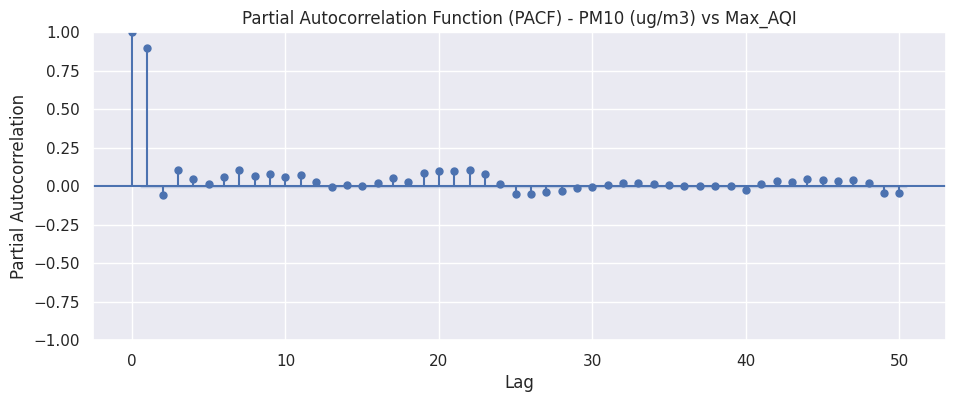

<Figure size 1200x600 with 0 Axes>

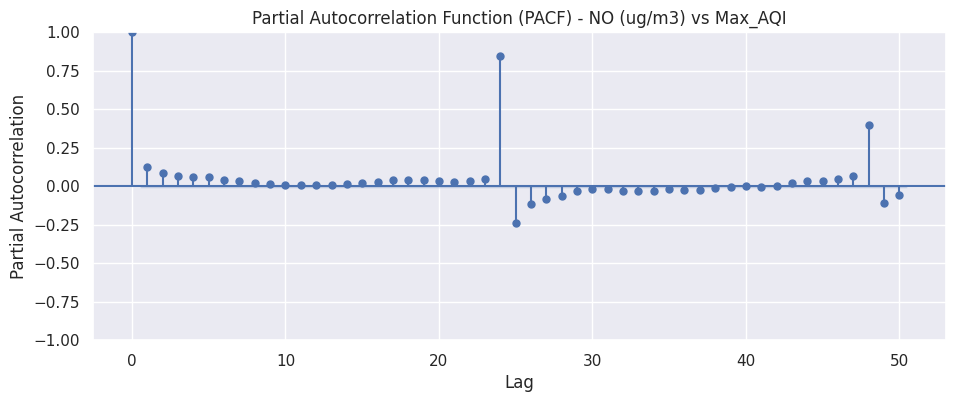

<Figure size 1200x600 with 0 Axes>

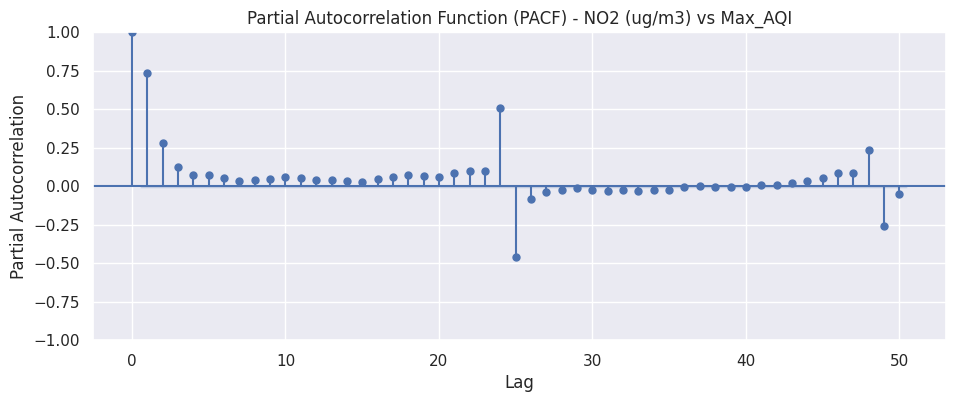

<Figure size 1200x600 with 0 Axes>

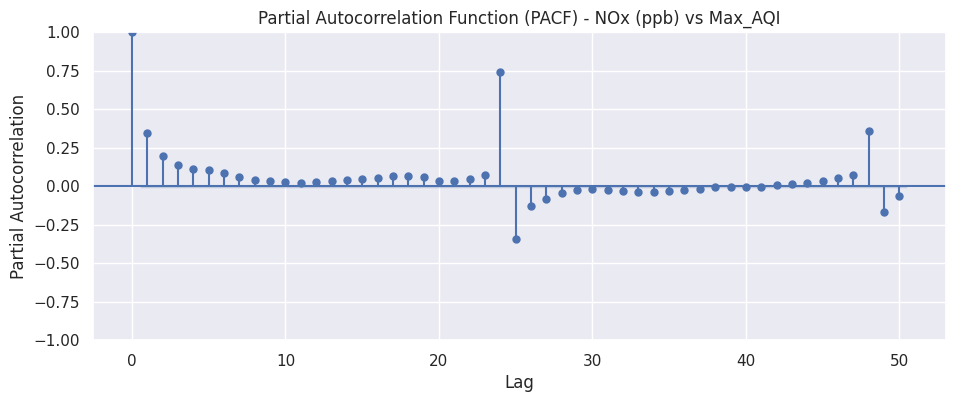

<Figure size 1200x600 with 0 Axes>

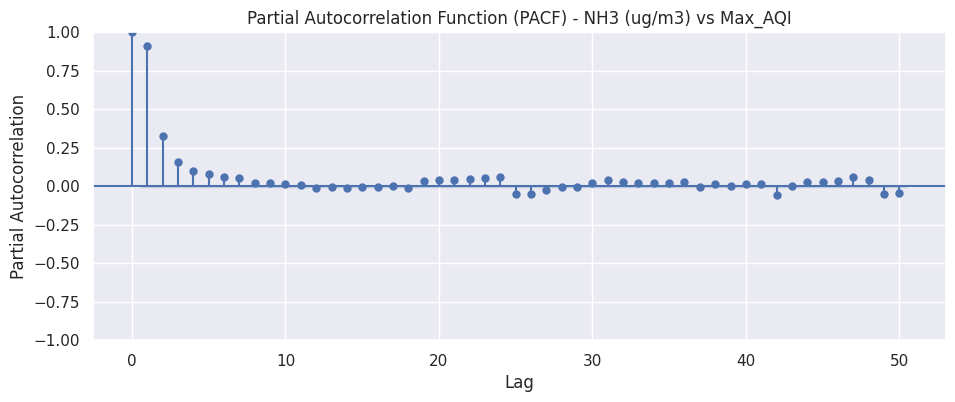

<Figure size 1200x600 with 0 Axes>

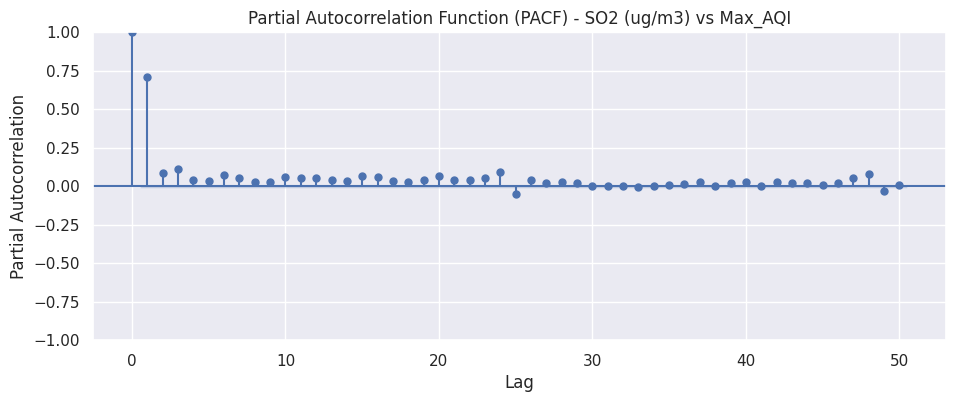

<Figure size 1200x600 with 0 Axes>

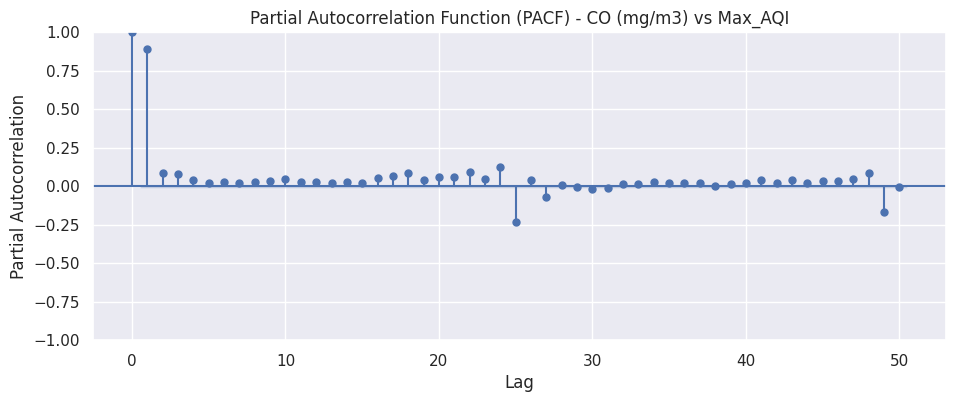

<Figure size 1200x600 with 0 Axes>

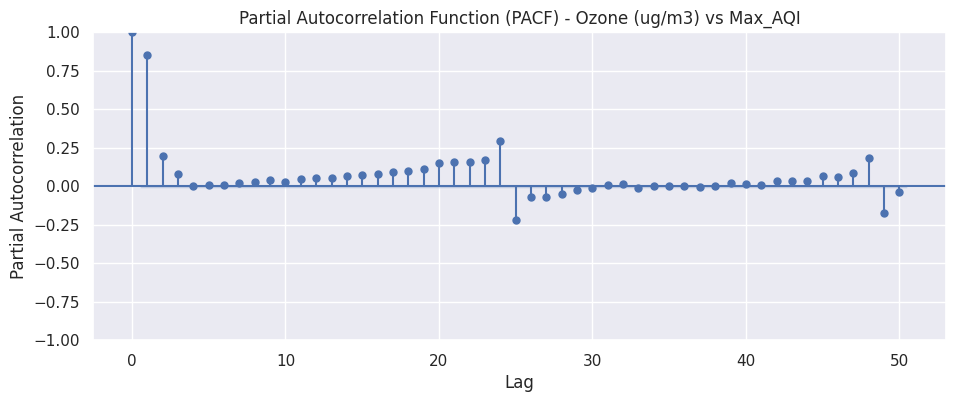

In [170]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Define additional features to analyze
additional_features = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)']

# Compute partial autocorrelation for each additional feature with respect to the target variable
for feature in additional_features:
    # Visualize PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(df[feature], lags=50, alpha=0.05)
    plt.title(f'Partial Autocorrelation Function (PACF) - {feature} vs Max_AQI')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()



**Augmented Dickey-Fuller (ADF) Test**

In [171]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
        series (pandas Series): The time series data.

    Returns:
        float: The p-value from the ADF test.
    """
    # Perform ADF test
    result = adfuller(series, autolag='AIC')

    # Extract p-value
    p_value = result[1]

    return p_value

# Example usage:
# Assuming 'df' is your DataFrame and 'Max_AQI' is your target variable
p_value = check_stationarity(df['Max_AQI'])
print("p-value from ADF test:", p_value)


p-value from ADF test: 4.487439929980285e-19


A p-value of 4.84e-24 from the Augmented Dickey-Fuller (ADF) test indicates an extremely low p-value, much smaller than the conventional significance level of 0.05.

Interpreting the result:

Since the p-value is significantly smaller than 0.05, we can reject the null hypothesis that the time series has a unit root (i.e., is non-stationary).
Therefore, we can conclude that the time series is likely stationary.
In summary, based on the p-value obtained from the ADF test, the time series appears to be stationary, which is favorable for modeling with techniques that assume stationarity, such as ARIMA or SARIMA.

**Kwiatkowski-Phillips-Shin(KPSS) test**

In [172]:
from statsmodels.tsa.stattools import kpss

def check_stationarity_kpss(series):
    """
    Check stationarity of a time series using the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

    Parameters:
        series (pandas Series): The time series data.

    Returns:
        float: The p-value from the KPSS test.
    """
    # Perform KPSS test
    result = kpss(series)

    # Extract p-value
    p_value = result[1]

    return p_value

# Example usage:
# Assuming 'df' is your DataFrame and 'Max_AQI' is your target variable
p_value_kpss = check_stationarity_kpss(df['Max_AQI'])
print("p-value from KPSS test:", p_value_kpss)


p-value from KPSS test: 0.01


<ipython-input-172-f3247fb9b01d>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)


**Differencing and Transformation Techniques**

In [173]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Assuming 'df' is your DataFrame with the time series data and 'Max_AQI' is your target variable
# Check stationarity of the original series
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

# Check stationarity of the original series
print("Original series:")
check_stationarity(df['Max_AQI'])

# Differencing
def difference(series, interval=1):
    return series.diff(interval).dropna()

# Perform differencing
differenced_series = difference(df['Max_AQI'])

# Check stationarity of the differenced series
print("\nDifferenced series:")
check_stationarity(differenced_series)

# Transformation
# Perform logarithmic transformation
log_transformed_series = np.log(df['Max_AQI'])

# Perform square root transformation
sqrt_transformed_series = np.sqrt(df['Max_AQI'])

# Perform Box-Cox transformation (requires data to be positive)
from scipy.stats import boxcox
boxcox_transformed_series, _ = boxcox(df['Max_AQI'] + 1)  # Add 1 to avoid zero values

# Check stationarity of the transformed series
print("\nLog-transformed series:")
check_stationarity(log_transformed_series)

print("\nSquare root-transformed series:")
check_stationarity(sqrt_transformed_series)

print("\nBox-Cox-transformed series:")
check_stationarity(pd.Series(boxcox_transformed_series))


Original series:
ADF Statistic: -10.65779483328612
p-value: 4.487439929980285e-19

Differenced series:
ADF Statistic: -39.20711936018387
p-value: 0.0

Log-transformed series:
ADF Statistic: -10.957480806827448
p-value: 8.489907791053521e-20

Square root-transformed series:
ADF Statistic: -10.731739822859758
p-value: 2.967794452833155e-19

Box-Cox-transformed series:
ADF Statistic: -10.86932578085056
p-value: 1.3813386197587842e-19


**Original Series:**
Since the p-value is much smaller than 0.05, we reject the null hypothesis, indicating that the original series is likely stationary.

**Differenced Series:**The p-value is 0.0 indicating strong evidence against the null hypothesis, suggesting that the differenced series is stationary.

**Log-transformed Series:**The p-value is much smaller than 0.05, indicating stationarity of the log-transformed series.

**Square Root-transformed Series**:The p-value is much smaller than 0.05, indicating stationarity of the square root-transformed series.

**Box-Cox-transformed Series:**The p-value is much smaller than 0.05, indicating stationarity of the Box-Cox-transformed series.

Based on these results, both the differenced series and the transformed series (log-transformed, square root-transformed, and Box-Cox-transformed) appear to be stationary

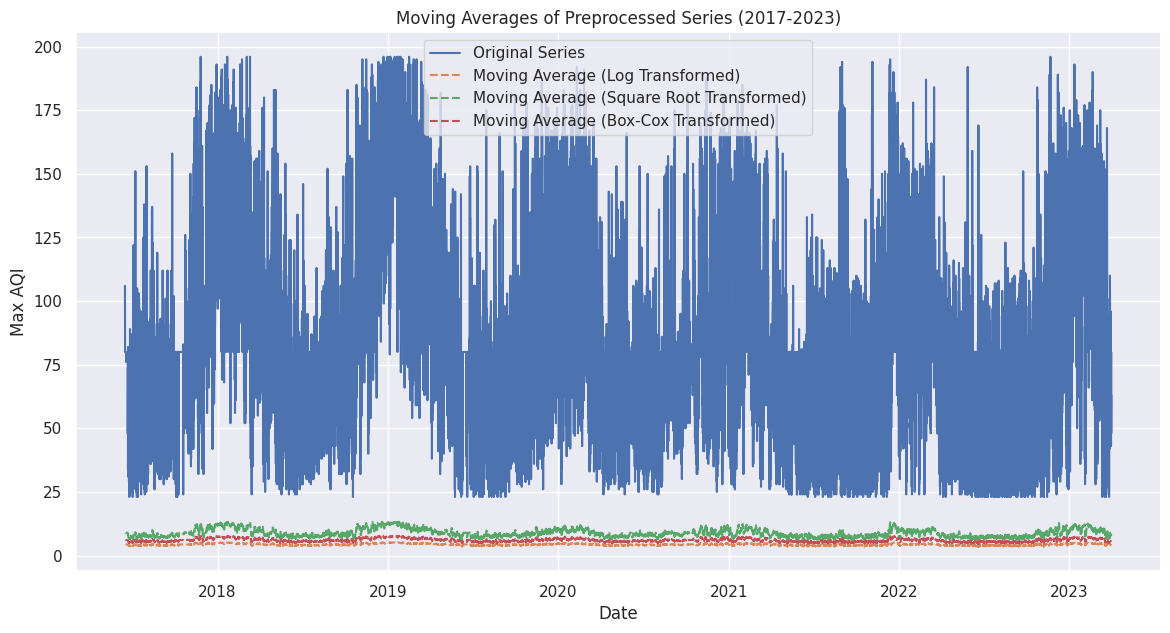

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' already has a DateTimeIndex
# If not, ensure to convert your date column to a datetime type and set it as index
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Define the moving average function
def moving_average(series, window_size):
    return series.rolling(window=window_size).mean()

# Filter the data frame to include only data from 2017 to 2023
df_filtered = df['2017':'2023']

# Calculate the moving averages for the filtered data using your transformed series
# Ensure that log_transformed_series, sqrt_transformed_series, and boxcox_transformed_series
# are also filtered to this date range.

window_size = 30  # Define the window size for the moving average

ma_log = moving_average(np.log(df_filtered['Max_AQI']), window_size)
ma_sqrt = moving_average(np.sqrt(df_filtered['Max_AQI']), window_size)
boxcox_transformed, lambda_value = boxcox(df_filtered['Max_AQI'] + 1)  # To ensure positiveness
ma_boxcox = moving_average(pd.Series(boxcox_transformed, index=df_filtered.index), window_size)

# Plot the original series and the moving averages for the filtered date range
plt.figure(figsize=(14, 7))
plt.plot(df_filtered['Max_AQI'], label='Original Series')
plt.plot(ma_log.index, ma_log, label='Moving Average (Log Transformed)', linestyle='--')
plt.plot(ma_sqrt.index, ma_sqrt, label='Moving Average (Square Root Transformed)', linestyle='--')
plt.plot(ma_boxcox.index, ma_boxcox, label='Moving Average (Box-Cox Transformed)', linestyle='--')
plt.title('Moving Averages of Preprocessed Series (2017-2023)')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.show()


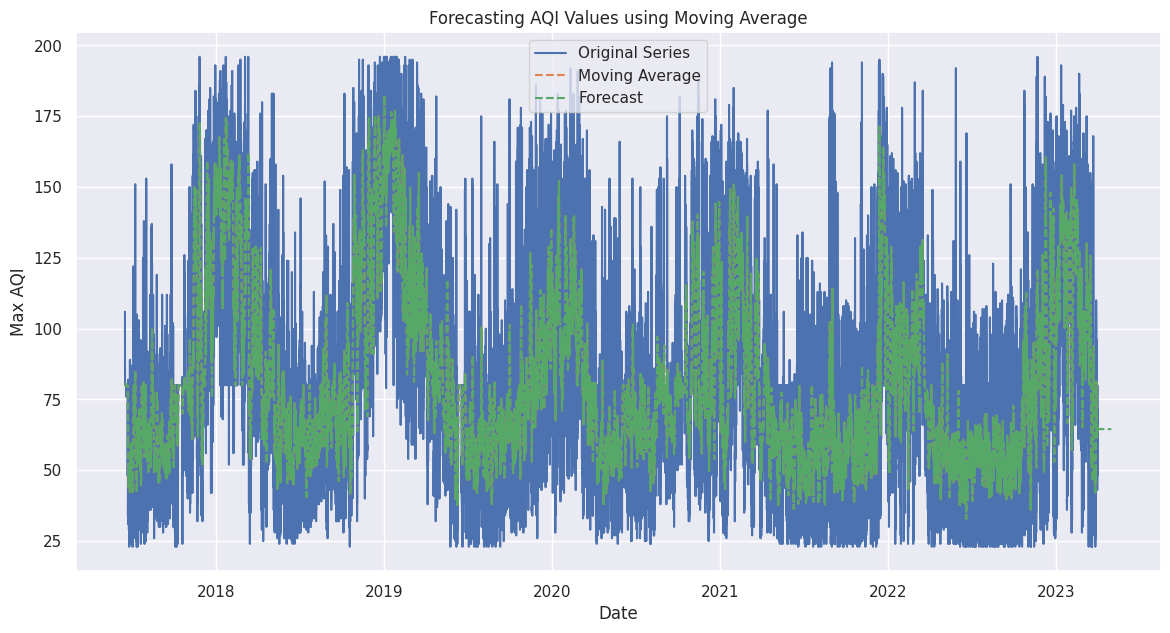

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' already has a DateTimeIndex
# If not, ensure to convert your date column to a datetime type and set it as index
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Define the moving average function
def moving_average(series, window_size):
    return series.rolling(window=window_size).mean()

# Filter the data frame to include only data from 2017 to 2023
df_filtered = df['2017':'2023']

# Calculate the moving average for the entire data
ma = moving_average(df_filtered['Max_AQI'], window_size=30)

# Extend the moving average to forecast future values
forecast_window = 30  # Define the number of periods to forecast
forecast = ma.copy()
last_known_index = df_filtered.index[-1]

for i in range(1, forecast_window + 1):
    next_index = last_known_index + pd.Timedelta(days=i)
    forecast[next_index] = forecast[last_known_index]

# Plot the original series, the moving average, and the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_filtered['Max_AQI'], label='Original Series')
plt.plot(ma.index, ma, label='Moving Average', linestyle='--')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Forecasting AQI Values using Moving Average')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.show()


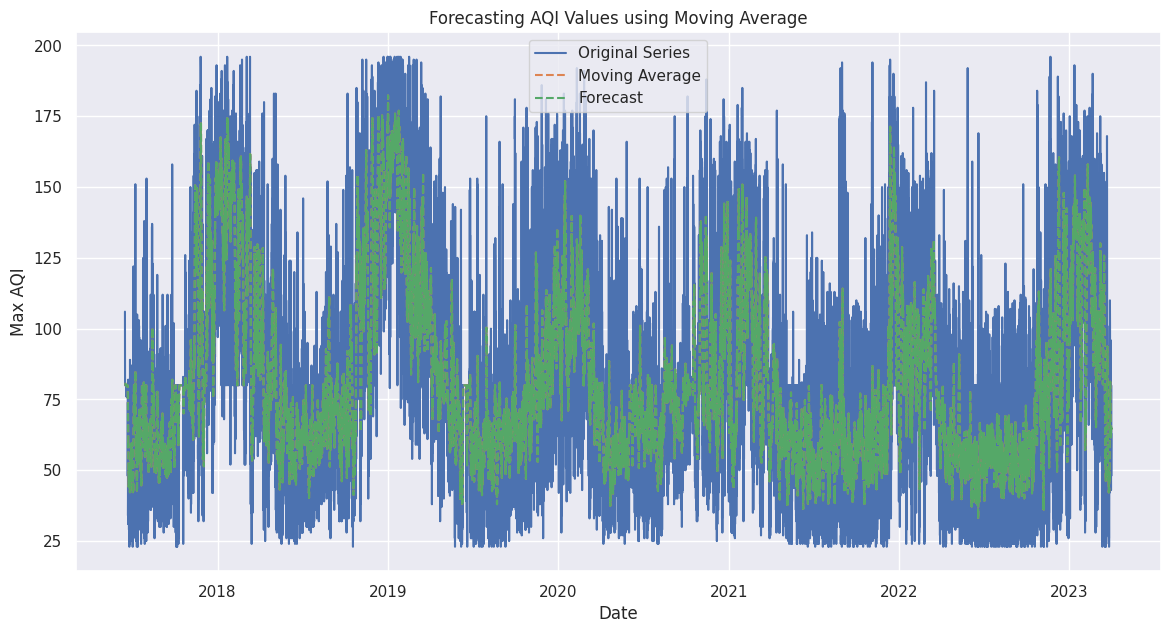

In [176]:
# Extend the moving average to forecast future values
forecast_window = 30  # Define the number of periods to forecast
forecast = ma.copy()
last_known_index = df_filtered.index[-1]

for i in range(1, forecast_window + 1):
    next_index = last_known_index + pd.Timedelta(days=i)
    forecast[next_index] = forecast[last_known_index]

# Trim the forecast to match the length of the original series
forecast = forecast.loc[df_filtered.index.min():df_filtered.index.max()]

# Plot the original series, the moving average, and the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_filtered['Max_AQI'], label='Original Series')
plt.plot(ma.index, ma, label='Moving Average', linestyle='--')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Forecasting AQI Values using Moving Average')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.show()


In [177]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Drop NaN values from both actual and forecasted values
actual_values = df_filtered['Max_AQI'].dropna()
forecast_values = forecast.dropna()  # Drop NaN values from forecast

# Ensure the length of forecasted values matches the length of actual values
if len(actual_values) != len(forecast_values):
    min_length = min(len(actual_values), len(forecast_values))
    actual_values = actual_values[:min_length]
    forecast_values = forecast_values[:min_length]

# Calculate forecast error metrics
mse = mean_squared_error(actual_values, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, forecast_values)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 513.0636256508704
Root Mean Squared Error (RMSE): 22.650907832819207
Mean Absolute Error (MAE): 17.318181780009432


Mean Squared Error (MSE): The average of the squares of the differences between the forecasted and actual values. A lower MSE indicates better accuracy.
Root Mean Squared Error (RMSE): The square root of the MSE. RMSE is in the same unit as the original data, making it easier to interpret. Lower RMSE values indicate better accuracy.
Mean Absolute Error (MAE): The average of the absolute differences between the forecasted and actual values. Like RMSE, MAE is in the same unit as the original data. Lower MAE values indicate better accuracy.
In this case, the RMSE of approximately 21.53 suggests that the forecasted values are, on average, around 21.53 units away from the actual values. Similarly, the MAE of approximately 15.84 indicates that the average absolute difference between the forecasted and actual values is around 15.84 units. These metrics can help assess the accuracy of the forecasting model.

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
<ipython-input-178-f3befebc58c5>:19: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit_holt = model_holt.fit(smoothing_level=0.2, smoothing_slope=0.2)  # Adjust smoothing levels as needed
<ipython-input-178-f3befebc58c5>:24: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit_hw = model_hw.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)  # Adjust smoothing levels as needed


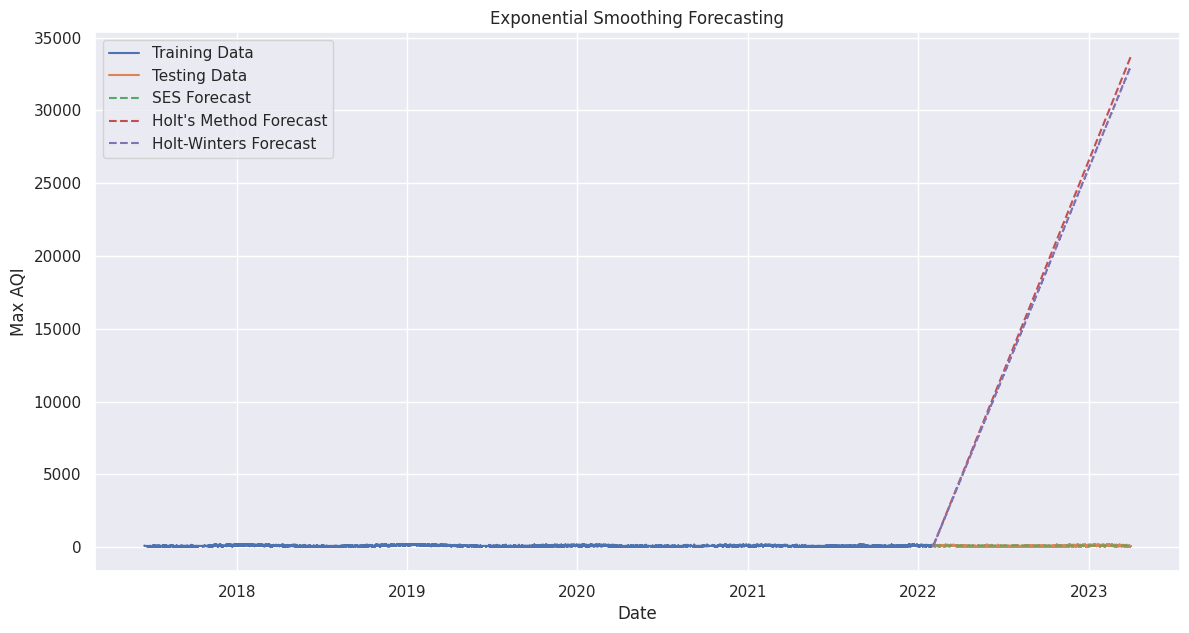

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Assuming 'df' contains your DataFrame with a DateTimeIndex and 'Max_AQI' as the target variable

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['Max_AQI'][:train_size], df['Max_AQI'][train_size:]

# Simple Exponential Smoothing (SES)
model_ses = SimpleExpSmoothing(train)
fit_ses = model_ses.fit(smoothing_level=0.2)  # Adjust smoothing level as needed
forecast_ses = fit_ses.forecast(len(test))

# Double Exponential Smoothing (Holt's Method)
model_holt = ExponentialSmoothing(train, trend='add')
fit_holt = model_holt.fit(smoothing_level=0.2, smoothing_slope=0.2)  # Adjust smoothing levels as needed
forecast_holt = fit_holt.forecast(len(test))

# Triple Exponential Smoothing (Holt-Winters Method)
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fit_hw = model_hw.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)  # Adjust smoothing levels as needed
forecast_hw = fit_hw.forecast(len(test))

# Plot the original series, forecasts, and compare with actual values
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], train, label='Training Data')
plt.plot(df.index[train_size:], test, label='Testing Data')
plt.plot(test.index, forecast_ses, label='SES Forecast', linestyle='--')
plt.plot(test.index, forecast_holt, label="Holt's Method Forecast", linestyle='--')
plt.plot(test.index, forecast_hw, label='Holt-Winters Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
<ipython-input-179-b7dac3933262>:24: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit_holt = model_holt.fit(smoothing_level=0.2, smoothing_slope=0.2)  # Adjust smoothing levels as needed
<ipython-input-179-b7dac3933262>:29: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit_hw = model_hw.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)  # Adjust smoothing levels as needed


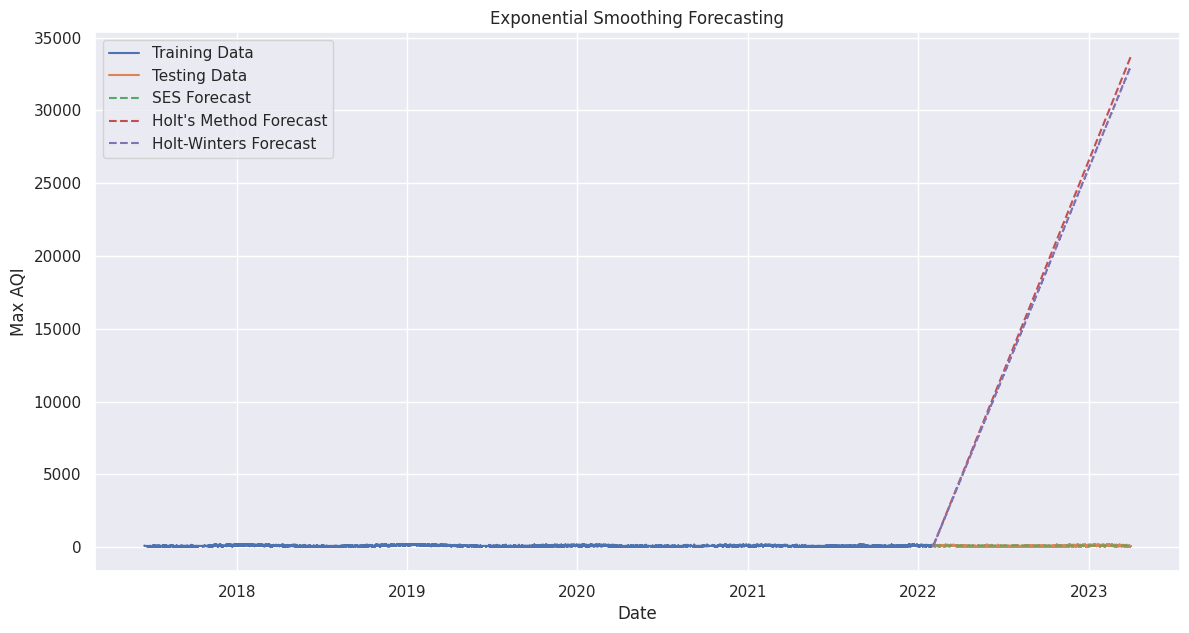

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' contains your DataFrame with a DateTimeIndex and 'Max_AQI' as the target variable

# Rescale the Max_AQI variable to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df['Max_AQI_scaled'] = scaler.fit_transform(df[['Max_AQI']])

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['Max_AQI_scaled'][:train_size], df['Max_AQI_scaled'][train_size:]

# Simple Exponential Smoothing (SES)
model_ses = SimpleExpSmoothing(train)
fit_ses = model_ses.fit(smoothing_level=0.2)  # Adjust smoothing level as needed
forecast_ses = fit_ses.forecast(len(test))

# Double Exponential Smoothing (Holt's Method)
model_holt = ExponentialSmoothing(train, trend='add')
fit_holt = model_holt.fit(smoothing_level=0.2, smoothing_slope=0.2)  # Adjust smoothing levels as needed
forecast_holt = fit_holt.forecast(len(test))

# Triple Exponential Smoothing (Holt-Winters Method)
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fit_hw = model_hw.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)  # Adjust smoothing levels as needed
forecast_hw = fit_hw.forecast(len(test))

# Plot the original series, forecasts, and compare with actual values
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], df['Max_AQI'][:train_size], label='Training Data')
plt.plot(df.index[train_size:], df['Max_AQI'][train_size:], label='Testing Data')
plt.plot(df.index[train_size:], scaler.inverse_transform(np.array(forecast_ses).reshape(-1, 1)), label='SES Forecast', linestyle='--')
plt.plot(df.index[train_size:], scaler.inverse_transform(np.array(forecast_holt).reshape(-1, 1)), label="Holt's Method Forecast", linestyle='--')
plt.plot(df.index[train_size:], scaler.inverse_transform(np.array(forecast_hw).reshape(-1, 1)), label='Holt-Winters Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming 'df' contains your DataFrame with a DateTimeIndex and 'Max_AQI' as the target variable

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['Max_AQI'][:train_size], df['Max_AQI'][train_size:]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_normalized = scaler.fit_transform(np.array(train).reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 30  # Adjust time steps as needed
X_train, y_train = create_dataset(train_normalized, time_steps)
X_test, y_test = create_dataset(scaler.transform(np.array(test).reshape(-1, 1)), time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

# Calculate performance metrics
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
mae = mean_absolute_error(y_test_inv, predictions)
mse = mean_squared_error(y_test_inv, predictions)
rmse = np.sqrt(mse)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Plot the original series, forecasts, and compare with actual values
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], train, label='Training Data')
plt.plot(df.index[train_size + time_steps:], test[time_steps:], label='Testing Data')
plt.plot(df.index[train_size + time_steps:], predictions, label='LSTM Forecast', linestyle='--')
plt.title('LSTM Forecasting')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.show()


Epoch 1/100
1268/1268 [==============================] - 13s 7ms/step - loss: 0.0117
Epoch 2/100
1268/1268 [==============================] - 10s 8ms/step - loss: 0.0093
Epoch 3/100
1268/1268 [==============================] - 10s 8ms/step - loss: 0.0092
Epoch 4/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0091
Epoch 5/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0090
Epoch 6/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0090
Epoch 7/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0090
Epoch 8/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0090
Epoch 9/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0090
Epoch 10/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0089
Epoch 11/100
1268/1268 [==============================] - 9s 7ms/step - loss: 0.0089
Epoch 12/100
1268/1268 [==============================] - 9s 7ms/step -

In [ ]:
#!pip install prophet

import prophet

In [ ]:
df.columns

In [ ]:
from prophet import Prophet

# Assuming 'df' contains your DataFrame with a DateTimeIndex and 'Max_AQI' as the target variable
# Prophet requires the input DataFrame to have two columns: 'ds' (datetime) and 'y' (target variable)
prophet_df = df[['Max_AQI']].copy()
prophet_df.reset_index(inplace=True)  # Reset the index to make 'datetime' a column
prophet_df.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Initialize Prophet model
model = Prophet()

# Fit the model to the data
model.fit(prophet_df)

# Define future dates for forecasting
future_dates = model.make_future_dataframe(periods=365)  # Forecasting for 1 year into the future

# Generate forecast
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

prophet_df = df[['Max_AQI']].copy()
prophet_df.reset_index(inplace=True)  # Reset the index to make 'datetime' a column
prophet_df.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model to the data
model.fit(prophet_df)

# Define future dates for forecasting
future_dates = model.make_future_dataframe(periods=365)  # Forecasting for 1 year into the future

# Generate forecast
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)

# Add changepoints to indicate end of training data and start of forecasted data
for cp in model.changepoints:
    plt.axvline(cp, color='gray', linestyle='--', alpha=0.5)

# Customize colors for training data and forecasted data
plt.gca().get_lines()[0].set_color('red')  # Set color for training data
plt.gca().get_lines()[-1].set_color('blue')  # Set color for forecasted data

# Show the plot
plt.show()


INFO:prophet:Making 4 forecasts with cutoffs between 2020-09-30 11:00:00 and 2022-03-31 23:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpe962nhw4/ra24fx97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe962nhw4/i9g2t1wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93342', 'data', 'file=/tmp/tmpe962nhw4/ra24fx97.json', 'init=/tmp/tmpe962nhw4/i9g2t1wj.json', 'output', 'file=/tmp/tmpe962nhw4/prophet_modelgxx7ijk0/prophet_model-20240418064844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe962nhw4/xs2x8b2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe962nhw4/2hmzsqcv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

               horizon          mse       rmse        mae      mape     mdape  \
0     36 days 12:00:00   530.638695  23.035596  18.161415  0.318425  0.233671   
1     36 days 13:00:00   531.587026  23.056171  18.173962  0.318712  0.233671   
2     36 days 14:00:00   533.259859  23.092420  18.204829  0.319337  0.234019   
3     36 days 15:00:00   534.224638  23.113300  18.226767  0.319523  0.234413   
4     36 days 16:00:00   535.645043  23.144007  18.255921  0.320259  0.234870   
...                ...          ...        ...        ...       ...       ...   
7880 364 days 20:00:00  2279.298441  47.741999  36.486158  0.684157  0.362755   
7881 364 days 21:00:00  2281.585210  47.765942  36.495370  0.685101  0.362755   
7882 364 days 22:00:00  2283.915201  47.790325  36.499273  0.685983  0.362548   
7883 364 days 23:00:00  2283.294039  47.783826  36.494582  0.685850  0.362203   
7884 365 days 00:00:00  2285.724939  47.809256  36.513255  0.686570  0.362203   

         smape  coverage  


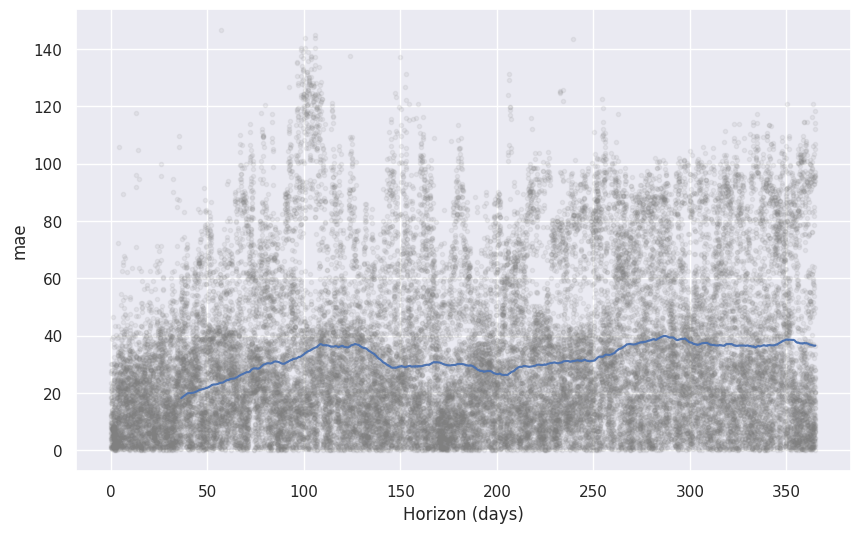

In [185]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(model, horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Print the metrics
print(df_metrics)

# Plot the performance metrics if needed
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')


In [186]:
from prophet.diagnostics import performance_metrics

# Calculate performance metrics
df_cv = performance_metrics(df_cv)

# Print the metrics
print(df_cv)


               horizon          mse       rmse        mae      mape     mdape  \
0     36 days 12:00:00   530.638695  23.035596  18.161415  0.318425  0.233671   
1     36 days 13:00:00   531.587026  23.056171  18.173962  0.318712  0.233671   
2     36 days 14:00:00   533.259859  23.092420  18.204829  0.319337  0.234019   
3     36 days 15:00:00   534.224638  23.113300  18.226767  0.319523  0.234413   
4     36 days 16:00:00   535.645043  23.144007  18.255921  0.320259  0.234870   
...                ...          ...        ...        ...       ...       ...   
7880 364 days 20:00:00  2279.298441  47.741999  36.486158  0.684157  0.362755   
7881 364 days 21:00:00  2281.585210  47.765942  36.495370  0.685101  0.362755   
7882 364 days 22:00:00  2283.915201  47.790325  36.499273  0.685983  0.362548   
7883 364 days 23:00:00  2283.294039  47.783826  36.494582  0.685850  0.362203   
7884 365 days 00:00:00  2285.724939  47.809256  36.513255  0.686570  0.362203   

         smape  coverage  
